## Water dataset

The aim of this workbook is to make an easy and accessible classification dataset which can be used wherever the ubiquitous Iris or Penguins dataset are used. 

Raw data comes from the Water Quality Archive of the UK Environment Agency. The raw data includes hundreds of determinands, some of which are observed very infrequently, and some of which are highly related to other determinands. Only a handful of determinands will be chosen for the final dataset.  

The classification is for types of water. We will select from the following classes: 

<table style="table-layout: fixed ; width: 100%;">
  <tr>
    <th>River water</th>
    <th>Canal water</th>
    <th>Lake water</th>
    <th>Groundwater</th>
    <th>Estuary water</th>
  </tr>
  <tr>
    <td style='text-align:center; vertical-align:middle'><img src="images/A River Bank (The Seine at Asnières) - Seurat.jpg" width=200 height=150></td>
    <td style='text-align:center; vertical-align:middle'><img src="images/A Regatta on the Grand Canal - Canaletto.jpg" width=200 height=150></td>
    <td style='text-align:center; vertical-align:middle'><img src="images/Lakeside Landscape - Renoir.jpg" width=200 height=150></td>
    <td style='text-align:center; vertical-align:middle'><img src="images/At the Well - Edward Bird.jpg" width=200 height=150></td>
    <td style='text-align:center; vertical-align:middle'><img src="images/Thames Painting - The Estuary (Mouth of the Thames) - Michael Andrews.avif" width=200 height=150></td>
  </tr>
  <tr>
    <td><i> A River Bank (The Seine at Asnières) </i></td>
    <td><i> A Regatta on the Grand Canal </i></td>
    <td><i> Lakeside Landscape </i></td>
    <td><i> At the Well </i></td>
    <td><i> Thames Painting - The Estuary </i></td>
  </tr>
  <tr>
    <td> Georges Seurat </td>
    <td> Canaletto </td>
    <td> Pierre-Auguste Renoir </td>
    <td> Edward Bird </td>
    <td> Michael Andrews </td>
  </tr>
  <tr>
    <td> 1883 </td>
    <td> 1740 </td>
    <td> 1889 </td>
    <td> c. 1800 </td>
    <td> 1995 </td>
  </tr>
</table>

(Groundwater is the water present beneath Earth's surface in rock and soil pore spaces and in the fractures of rock formations, and is often withdrawn via wells.)


In [2]:
import numpy as np
import pandas as pd

import sklearn.tree
import sklearn.ensemble

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display

import os
import sys
import zipfile

### Water quality raw datasets

Data source: https://environment.data.gov.uk/water-quality/view/download


### Memory issues 

To get enough data, we need several years worth. There is one csv for each year of data, and many of the csv files are over a GB in size when uncompressed. The earlier years are particularly large. This means a lot of memory is required to load the data!    



In [18]:
files = sorted([os.path.join('data', file) 
                for file in os.listdir('data') 
                if (file.startswith('20') and file.endswith('.zip'))])

zip_uncompressed_full_size = lambda zip_file : sum([zinfo.file_size for zinfo in zip_file.filelist])

zip_sizes = [{'file':file, 
              'compressed size (MB)':os.path.getsize(file) / 1024**2, 
              'uncompressed size (MB)':zip_uncompressed_full_size(zipfile.ZipFile(file)) / 1024**2}
                    for file in files]
zip_sizes = pd.DataFrame(zip_sizes)

zip_sizes.loc['sum', ['compressed size (MB)','uncompressed size (MB)']] = zip_sizes[
    ['compressed size (MB)','uncompressed size (MB)']].sum(axis=0)

zip_sizes.round(2).fillna('')

,file,compressed size (MB),uncompressed size (MB)
0,data\2000.zip,70.27,1673.88
1,data\2001.zip,56.37,1326.45
2,data\2002.zip,65.12,1551.44
3,data\2003.zip,63.88,1517.41
4,data\2004.zip,62.53,1438.36
5,data\2005.zip,60.97,1388.11
6,data\2006.zip,60.77,1351.05
7,data\2007.zip,56.93,1255.21
8,data\2008.zip,51.88,1112.80
9,data\2009.zip,44.34,951.12


To mitigate this, we inspect memory usage of one file (from one year), to see which columns there should be loaded as categorical (which can use much less memory, as for each record it is stored as an integer instead of a text string). We then use our findings to guide loading all the files. 



In [2]:
def df_memory_usage(df, 
    compare_to_categorical=True, show_pie=True, show_memory_numbers=True, 
    make_recommendations=True, downcast_ints=False, silent=False):
    '''Given a dataframe, can:
        - visualise memory usage for each column with a pie chart (`show_pie`)
        - show memory usage for each column with a table (`show_memory_numbers`)
        - recommend which columns should be changed to categorical (`compare_to_categorical`, `make_recommendations`)
        - recommend which columns should be changed to lower-memory int types (`downcast_ints`, `make_recommendations`)'''


    memory_usage = pd.DataFrame()
    memory_usage['memory (MB)'] = (df.memory_usage(deep=True) / 1024**2)
    memory_usage['dtype'] = (df.dtypes)
    memory_usage['sample data: first row'] = df.iloc[0]

    memory_usage = memory_usage.sort_values(by='memory (MB)')


    if show_pie:

        # make nice labels using col name and memory of col
        labels = (memory_usage.index + ': ' + 
            memory_usage['dtype'].astype(str) + ' - ' + 
            memory_usage['memory (MB)'].round().astype(int).astype(str) + ' MB')
        # only show cols which have a memory usage of more than 5% of total
        labels.iloc[memory_usage['memory (MB)'] < memory_usage['memory (MB)'].sum() * .05] = ''

        if compare_to_categorical:
            fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(12,6))
        else:
            fig, ax = plt.subplots(ncols=1, figsize=(6,6))

        ax.pie(memory_usage['memory (MB)'], labels=labels)


    if not silent:
        print('dataframe total memory usage:', round(sys.getsizeof(df) / 1024**2, 2), 'MB.    Shape:', df.shape)



    if compare_to_categorical:
        df_categorical = df.select_dtypes(include=object).copy().astype('category')
        memory_usage['n unique values'] = df.nunique()
        memory_usage['memory if categorical (MB)'] = (df_categorical.memory_usage(deep=True, index=False) / 1024**2)


        if make_recommendations:

            # recommend changing dtype to categorical if it saves 20% memory. Otherwise, keep old dtype
            memory_usage['recommended dtype'] = memory_usage['dtype']

            categorical_saves_memory = (memory_usage['memory if categorical (MB)'] < memory_usage['memory (MB)']*.8)
            memory_usage.iloc[categorical_saves_memory, memory_usage.columns.get_loc('recommended dtype')] = 'category'



            if downcast_ints:
                int_dtypes = np.unsignedinteger.__subclasses__() + np.signedinteger.__subclasses__() 
                int_dtypes = [np.iinfo(int_dtype) for int_dtype in int_dtypes if int_dtype!=np.timedelta64]
                int_dtypes = sorted(int_dtypes, key=lambda x: x.bits )
                # print(int_dtypes)


                ints = df.select_dtypes(include=int).agg(func=['min','max']).T

                # ints['rec'] = np.int64
                for idx, row in ints.iterrows():
                    # print(row[1])
                    for int_dtype in int_dtypes:
                        if (row['min']>=int_dtype.min) and (row['max']<=int_dtype.max):
                            memory_usage.loc[idx, 'recommended dtype'] = int_dtype.dtype
                            break




            dtype_map = memory_usage['recommended dtype'].to_dict()
            del(dtype_map['Index'])

            df_recommended_dtypes = df.astype(dtype=dtype_map, copy=True)

            if not silent:
                print('total memory usage, using recommended map:', round(sys.getsizeof(df_recommended_dtypes) / 1024**2, 2), 'MB')
                print('recommended dtypes:', dtype_map)

            memory_usage['memory for recommended dtypes (MB)'] = (df_recommended_dtypes.memory_usage(deep=True, index=True) / 1024**2)


            if show_pie:
                # make nice labels using col name and memory of col
                labels = (memory_usage.index + ': ' + 
                    memory_usage['dtype'].astype(str) + ' - ' + 
                    memory_usage['memory for recommended dtypes (MB)'].round().astype(int).astype(str) + ' MB')
                # only show cols which have a memory usage of more than 5% of total
                labels.iloc[memory_usage['memory for recommended dtypes (MB)'] < memory_usage['memory for recommended dtypes (MB)'].sum() * .05] = ''

                ax2.pie(memory_usage['memory for recommended dtypes (MB)'], labels=labels)
                ax .set_title('Memory usage per column - Original')
                ax2.set_title('Memory usage per column - Recommended')

                plt.tight_layout()



    if show_memory_numbers:
        memory_usage.loc['TOTAL'] = memory_usage[[col for col in memory_usage.columns if 'memory' in col]].sum()
        # memory_usage.loc['TOTAL'] = memory_usage.sum(numeric_only=True)
        memory_usage.loc['TOTAL'] = memory_usage.loc['TOTAL'].fillna('')
        memory_usage.loc['Index'] = memory_usage.loc['Index'].fillna('')
        if compare_to_categorical:
            memory_usage['memory if categorical (MB)'] = memory_usage['memory if categorical (MB)'].fillna('')

        IPython.display.display(memory_usage)



    if compare_to_categorical and make_recommendations:
        return memory_usage, dtype_map
    else:
        return memory_usage, None



dataframe total memory usage: 1387.93 MB.    Shape: (1513257, 17)
total memory usage, using recommended map: 291.87 MB
recommended dtypes: {'sample.isComplianceSample': dtype('bool'), 'codedResultInterpretation.interpretation': dtype('float64'), 'result': dtype('float64'), 'sample.samplingPoint.easting': dtype('int64'), 'determinand.notation': dtype('int64'), 'sample.samplingPoint.northing': dtype('int64'), 'resultQualifier.notation': 'category', 'determinand.unit.label': 'category', 'determinand.label': 'category', 'sample.samplingPoint.notation': 'category', 'sample.sampleDateTime': 'category', 'determinand.definition': 'category', 'sample.sampledMaterialType.label': 'category', 'sample.samplingPoint.label': 'category', 'sample.purpose.label': 'category', 'sample.samplingPoint': 'category', '@id': dtype('O')}


,memory (MB),dtype,sample data: first row,n unique values,memory if categorical (MB),recommended dtype,memory for recommended dtypes (MB)
Index,0.000122,,,,,,0.000122
sample.isComplianceSample,1.443154,bool,True,2.0,,bool,1.443154
codedResultInterpretation.interpretation,11.545235,float64,NaN,0.0,,float64,11.545235
result,11.545235,float64,5.1,23899.0,,float64,11.545235
sample.samplingPoint.easting,11.545235,int64,467993,12534.0,,int64,11.545235
determinand.notation,11.545235,int64,111,1249.0,,int64,11.545235
sample.samplingPoint.northing,11.545235,int64,232851,12826.0,,int64,11.545235
resultQualifier.notation,56.711924,object,NaN,2.0,1.443368,category,1.443368
determinand.unit.label,88.300207,object,mg/l,47.0,1.446944,category,1.446944
determinand.label,96.644202,object,Ammonia(N),1228.0,2.996656,category,2.996656


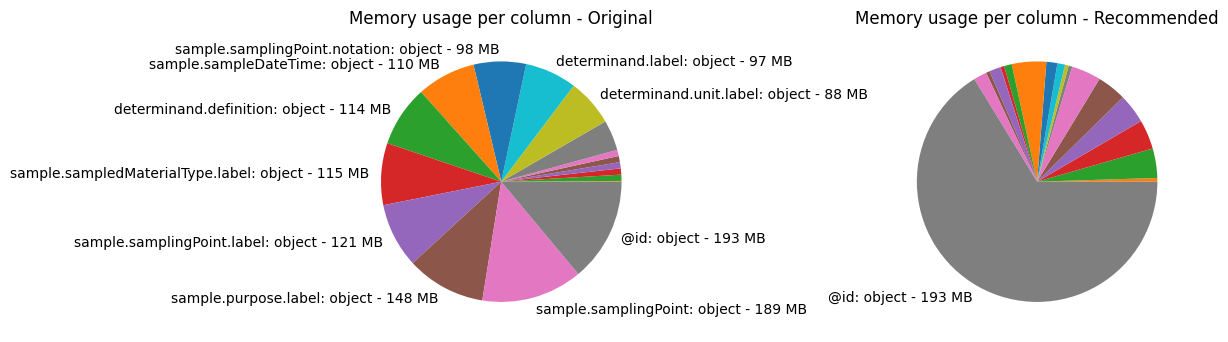

In [3]:
water = pd.read_csv('data\\2022.zip')

memory_usage, dtype_map = df_memory_usage(water)

So this method has identified substantial memory savings in all of the columns apart from `@id` of over 80%, or more than a GB.  

The truth is that looking at the `@id` column shows that this also isn't important for us. It is simply a web address for the specific observation (so it is different for each observation, which is why no memory was saved by making it categorical). E.g. for one observation it is `http://environment.data.gov.uk/water-quality/data/measurement/AN-1959931-0135`.   

So we can simply skip this column and save even more: 

In [4]:
cols_to_load = [col for col in water.columns if col!='@id']

In [5]:
water = pd.read_csv('data\\2022.zip', usecols=cols_to_load, dtype=dtype_map)

print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
del(water)

dataframe total memory usage: 98.49 MB.    Shape: (1513257, 16)


So we are down from over 1300 MB to under 100 MB for one `csv`. This will make it possible to load several `csv`'s like this despite memory constraints.  

Note: `downcast_ints` in the earlier function was set to `False` - if this would be set to `True` some further saving would be made. However there is the risk that csv's loaded later would have different ranges of int's to the first csv, and that using this could end up corrupting the data.

### Concatenation of categorical columns

Simple concatenation of the different `.csv` files will mess up the category dtypes. When there are different categories in the different dfs being concatenated, `pd.concat` doesn't preserve the categorical dtype, but changes it all back to object instead... So for example if a sample location is present in the 2001 `csv` but not in the 2000 `csv`, we will lose all our hard work loading those columns from each csv as categorical data, as at the point of concatenation they will be changed back to objects, with the associated memory cost meaning a typical laptop would run out of memory.  

The following function works around this by changing each year's dataframe so that the categories are the same for each before concatenating them.



In [6]:
def concat_categorical_df(dfs, check_correct=False, **concat_kwargs):
    '''Given a list of pandas dataframes, concatenates them, preserving categorical dtypes.
    
    Just using pd.concat on a list of dfs with categorical cols can go wrong:
        If the categories of the col are different in any of the dfs, then it is changed to an object.
        It is only preserved as a categorical col if categories are the same across all dfs (for that col).
    We often want to preserve the categorical nature of the col during the concat.
        Although we could just concat and then change the cols back into categorical, 
            that could use too much memory (memory efficiency is a major advantage of categorical).
    This function preserves the categorical cols even during the concatenation, 
        to remain memory-efficient.

    Note: Only cols which are categorical in ALL the supplied dfs will be treated as categorical.
        If in one of the dfs a col is say an object, it won't be considered categorical 
            and will therefore end up being concatenated into an object col.

    Note 2: To see how it is working you can uncomment the print lines.

    Note 3: It works by first changing the categories for each df and each col 
        such that each col has same categories in ALL dfs.
        Once that is done, and all dfs have matching categories, they can be concatenated as usual.
    
    To be confident that data isn't changed when the categories change, 
        setting check_correct=True will:
        1. store a copy of each col of each df 
        2. change the categories, 
        3. compare the col before and after change of categories, by converting to objects
        as this takes time it is False by default
    '''

    cols_which_are_categorical_in_all_dfs = [set(df.dtypes.index[df.dtypes=='category']) for df in dfs]
    # print(*cols_which_are_categorical_in_all_dfs, sep='\n')

    cols_which_are_categorical_in_all_dfs = set.intersection(*cols_which_are_categorical_in_all_dfs)
    # print(cols_which_are_categorical_in_all_dfs)


    for col in cols_which_are_categorical_in_all_dfs:
        all_categories_this_col = sorted(set.union(*[set(df[col].cat.categories) for df in dfs]))

        # print(col)
        for df in dfs:
            if check_correct: df_col_copy = df[col].copy()                                        # to check working properly
            # print(df[col])
            df[col] = df[col].cat.set_categories(all_categories_this_col)
            # print(df[col])
            if check_correct: assert df_col_copy.astype(object).equals(df[col].astype(object))    # to check working properly
        #     print()
        # print('='*100)
        # print()
            

    return pd.concat(dfs, **concat_kwargs)



In [7]:

files = sorted([os.path.join('data', file) for file in os.listdir('data') if (file.startswith('20') and file.endswith('.zip'))])
print(files)
print()

# simple concatenation messes up the category dtypes
# because when there are different categories in the different dfs being concated, 
# pd.concat doesn't preserve the categorical dtype but changes it all back to object instead...
# water = pd.concat([pd.read_csv(file, compression='zip', usecols=cols_to_load, dtype=dtype_map) 
#                         for file in files], 
#                     axis=0, ignore_index=True)


water = [pd.read_csv(file, compression='zip', usecols=cols_to_load, dtype=dtype_map) 
                        for file in files]


mem = [sys.getsizeof(water_year) / 1024**2 for water_year in water]
print('yearly dataframes memory usage:', [round(m,2) for m in mem], 'MBs')

print('yearly dataframes sum memory usage:', round(sum(mem), 2), 'MB')
print()

water = concat_categorical_df(dfs=water, axis=0, ignore_index=True)


print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)

water

['data\\2000.zip', 'data\\2001.zip', 'data\\2002.zip', 'data\\2003.zip', 'data\\2004.zip', 'data\\2005.zip', 'data\\2006.zip', 'data\\2007.zip', 'data\\2008.zip', 'data\\2009.zip', 'data\\2010.zip', 'data\\2011.zip', 'data\\2012.zip', 'data\\2013.zip', 'data\\2014.zip', 'data\\2015.zip', 'data\\2016.zip', 'data\\2017.zip', 'data\\2018.zip', 'data\\2019.zip', 'data\\2020.zip', 'data\\2021.zip', 'data\\2022.zip']

yearly dataframes memory usage: [296.59, 238.28, 276.53, 270.65, 258.53, 250.84, 243.93, 224.8, 200.36, 171.34, 161.69, 164.57, 171.68, 177.69, 150.52, 140.76, 133.63, 119.92, 102.8, 109.47, 49.54, 81.87, 98.49] MBs
yearly dataframes sum memory usage: 4094.46 MB

dataframe total memory usage: 4387.24 MB.    Shape: (66192992, 16)


,sample.samplingPoint,sample.samplingPoint.notation,sample.samplingPoint.label,sample.sampleDateTime,determinand.label,determinand.definition,determinand.notation,resultQualifier.notation,result,codedResultInterpretation.interpretation,determinand.unit.label,sample.sampledMaterialType.label,sample.isComplianceSample,sample.purpose.label,sample.samplingPoint.easting,sample.samplingPoint.northing
0,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-01-04T14:10:00,Ammonia(N),Ammoniacal Nitrogen as N,111,NaN,10.4,NaN,mg/l,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
1,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-01-04T14:10:00,Sld Sus@105C,"Solids, Suspended at 105 C",135,NaN,10.0,NaN,mg/l,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
2,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-01-04T14:10:00,BOD ATU,BOD : 5 Day ATU,85,NaN,7.5,NaN,mg/l,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
3,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-03-21T13:30:00,NO FLOW/SAMP,No flow /No sample,7668,NaN,0.0,NaN,coded,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
4,http://environment.data.gov.uk/water-quality/i...,AN-011396,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-06-28T13:20:00,Sld Sus@105C,"Solids, Suspended at 105 C",135,NaN,7.6,NaN,mg/l,FINAL SEWAGE EFFLUENT,True,COMPLIANCE AUDIT (PERMIT),467020,233400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66192987,http://environment.data.gov.uk/water-quality/i...,TH-WABE0001,HORNSEY WTW T/E SAMPLE POINT M,2022-03-23T07:18:00,NO FLOW/SAMP,No flow /No sample,7668,NaN,0.0,NaN,coded,ANY TRADE EFFLUENT,True,WATER QUALITY OPERATOR SELF MONITORING COMPLIA...,530520,189910
66192988,http://environment.data.gov.uk/water-quality/i...,TH-WABE0001,HORNSEY WTW T/E SAMPLE POINT M,2022-05-14T08:05:00,NO FLOW/SAMP,No flow /No sample,7668,NaN,0.0,NaN,coded,ANY TRADE EFFLUENT,True,WATER QUALITY OPERATOR SELF MONITORING COMPLIA...,530520,189910
66192989,http://environment.data.gov.uk/water-quality/i...,TH-WABE0001,HORNSEY WTW T/E SAMPLE POINT M,2022-07-18T08:04:00,NO FLOW/SAMP,No flow /No sample,7668,NaN,0.0,NaN,coded,ANY TRADE EFFLUENT,True,WATER QUALITY OPERATOR SELF MONITORING COMPLIA...,530520,189910
66192990,http://environment.data.gov.uk/water-quality/i...,TH-WABE0001,HORNSEY WTW T/E SAMPLE POINT M,2022-09-29T11:19:00,NO FLOW/SAMP,No flow /No sample,7668,NaN,0.0,NaN,coded,ANY TRADE EFFLUENT,True,WATER QUALITY OPERATOR SELF MONITORING COMPLIA...,530520,189910


The dataset is still extremely large, and we will prioritise processing it in ways which will decrease memory usage.

### Change datetimes to proper datetime format

In [8]:
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
water['sample.sampleDateTime'] = pd.to_datetime(water['sample.sampleDateTime'], format='%Y-%m-%dT%H:%M:%S')
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
# water

dataframe total memory usage: 4387.24 MB.    Shape: (66192992, 16)
dataframe total memory usage: 4268.18 MB.    Shape: (66192992, 16)


### Look at data - categorical / object cols

In [9]:
water.describe(include=['O', 'category']) 

,sample.samplingPoint,sample.samplingPoint.notation,sample.samplingPoint.label,sample.sampleDateTime,determinand.label,determinand.definition,resultQualifier.notation,determinand.unit.label,sample.sampledMaterialType.label,sample.purpose.label
count,66192992,66192992,66192992,66192992,66192992,66192992,17613346,66192992,66192992,66192992
unique,61576,61576,61355,1836029,3005,2951,3,110,153,32
top,http://environment.data.gov.uk/water-quality/i...,NW-88000045,MISC RIVER SAMPLES LUNE/WYRE,2011-01-01 00:07:00,Ammonia(N),Ammoniacal Nitrogen as N,<,mg/l,RIVER / RUNNING SURFACE WATER,ENVIRONMENTAL MONITORING STATUTORY (EU DIRECTI...
freq,106052,106052,106052,3032,2793449,2793460,17539066,26420379,32472624,30811009


### `resultQualifier.notation` column

The explanation of this column, which contains either < or > or nans:   
*"However, sometimes a measurement is only an upper or lower bound.*  
*For example, the laboratory test may not be able to detect the substance if it is below some concentration.*   
*In such cases the measurement will have an associated qualifier.*   
*For example, AN-1805502-0119 represents a measurement of less than 0.00059 mg/l of Ammonia (un-ionised as N) on a sample in 2015."*  
   \- https://environment.data.gov.uk/water-quality/view/doc/reference


We now drop values with a < or > which indicate that there isn't a precise reading :

In [10]:
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)

water = water[water['resultQualifier.notation'].isna()]

#and drop that col, as it is useless now :
water = water.drop('resultQualifier.notation', axis='columns')

print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)


dataframe total memory usage: 4268.18 MB.    Shape: (66192992, 16)
dataframe total memory usage: 3483.85 MB.    Shape: (48579646, 15)


### Sample location

There are several columns relating to location. We can probably remove some of these columns to simplify the dataset. Before doing so, we need to check whether there is a one-to-one mapping between those columns.

In [11]:
# 1. ensure each location code (samplingPoint) has the same API address always
# 2. ensure each location code (samplingPoint) has the same label always
# 3. ensure each location code (samplingPoint) has the same material type (e.g. river) always
# 4. ensure each location code (samplingPoint) has the same easting and northing always


groupby_samplingPointNotation = water[['sample.samplingPoint', 'sample.samplingPoint.notation',
       'sample.samplingPoint.label', #'sample.sampleDateTime',
       #'determinand.label', 'determinand.definition', 'determinand.notation',
       #'result', 'codedResultInterpretation.interpretation',
       #'determinand.unit.label', 
       'sample.sampledMaterialType.label',
       #'sample.isComplianceSample', 'sample.purpose.label',
       'sample.samplingPoint.easting', 'sample.samplingPoint.northing']
            ].groupby('sample.samplingPoint.notation'
            ).agg(['nunique', #pd.unique, 
                   lambda x: pd.unique(x) if len(pd.unique(x))>1 else ''
                   ])

sort_by_cols = [
 ('sample.samplingPoint', 'nunique'),
 ('sample.samplingPoint.label', 'nunique'),
 ('sample.samplingPoint.easting', 'nunique'),
 ('sample.samplingPoint.northing', 'nunique'),
 ('sample.sampledMaterialType.label', 'nunique'),
 ]

groupby_samplingPointNotation_multiple_types = groupby_samplingPointNotation[sort_by_cols].max(axis=1)>1

groupby_samplingPointNotation[groupby_samplingPointNotation_multiple_types].sort_values(by=sort_by_cols)[[a for (a, b) in sort_by_cols]].tail(5)

sample.samplingPoint             \
                                           nunique <lambda_0>   
sample.samplingPoint.notation                                   
MD-56083950                                      1              
MD-58471700                                      1              
MD-36773650                                      1              
NE-49000126                                      1              
TH-PGWE0003                                      1              

                              sample.samplingPoint.label  \
                                                 nunique   
sample.samplingPoint.notation                              
MD-56083950                                            1   
MD-58471700                                            1   
MD-36773650                                            1   
NE-49000126                                            2   
TH-PGWE0003                                            2   

                                                                                  \
                                                                      <lambda_0>   
sample.samplingPoint.notation                                                      
MD-56083950                                                                        
MD-58471700                                                                        
MD-36773650                                                                        
NE-49000126                    ['CLEVELAND POTASH LTD - BOULBY MINE', 'CLEVEL...   
TH-PGWE0003                    ['NEWLANDS CORNER STW :ALBURY***CLOSED', 'NEWL...   

                              sample.samplingPoint.easting                    \
                                                   nunique        <lambda_0>   
sample.samplingPoint.notation                                                  
MD-56083950                                              2  [407449, 407440]   
MD-58471700                                              2  [428315, 428300]   
MD-36773650                                              2  [403180, 403170]   
NE-49000126                                              1                     
TH-PGWE0003                                              1                     

                              sample.samplingPoint.northing                    \
                                                    nunique        <lambda_0>   
sample.samplingPoint.notation                                                   
MD-56083950                                               2  [342625, 342620]   
MD-58471700                                               2  [312537, 312470]   
MD-36773650                                               2  [319860, 319880]   
NE-49000126                                               1                     
TH-PGWE0003                                               1                     

                              sample.sampledMaterialType.label  \
                                                       nunique   
sample.samplingPoint.notation                                    
MD-56083950                                                  1   
MD-58471700                                                  1   
MD-36773650                                                  2   
NE-49000126                                                  2   
TH-PGWE0003                                                  3   

                                                                                  
                                                                      <lambda_0>  
sample.samplingPoint.notation                                                     
MD-56083950                                                                       
MD-58471700                                                                       
MD-36773650                    ['FINAL SEWAGE EFFLUENT', 'ANY SEWAGE']
Catego...  
NE-49000126                    ['ANY T

In [12]:
# example of location with multiple types of water

# water[water['sample.samplingPoint.notation']=='NW-88021139']

So all location CODES (`sample.samplingPoint.notation`) can have multiple of each of the following:
 - `sample.samplingPoint.easting`
 - `sample.samplingPoint.northing`
 - `sampledMaterialType`
 - `sample.samplingPoint.label`. 

But only one `sample.samplingPoint` - this is because `sample.samplingPoint` is simply a web address which includes `sample.samplingPoint.notation`. E.g. when `sample.samplingPoint.notation` is `AN-011553`, the `sample.samplingPoint` is `http://environment.data.gov.uk/water-quality/id/sampling-point/AN-011553`.

We could split each location into the different types of water at that location, however for simplicity we will just drop those locations with  multiple `sampledMaterialType`'s.

In [13]:
groupby_samplingPointNotation_multiple_types_names = groupby_samplingPointNotation_multiple_types.index[groupby_samplingPointNotation_multiple_types]
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
water = water[~water['sample.samplingPoint.notation'].isin(groupby_samplingPointNotation_multiple_types_names)]
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
# water


dataframe total memory usage: 3483.85 MB.    Shape: (48579646, 15)
dataframe total memory usage: 2126.02 MB.    Shape: (29075744, 15)


We need to check the other way round - do all location LABELS have only one code?

In [14]:
# 1. ensure each location code (samplingPoint) has the same API address always
# 2. ensure each location code (samplingPoint) has the same label always
# 3. ensure each location code (samplingPoint) has the same material type (e.g. river) always
# 4. ensure each location code (samplingPoint) has the same easting and northing always


groupby_samplingPointLabel = water[['sample.samplingPoint', 'sample.samplingPoint.notation',
       'sample.samplingPoint.label', #'sample.sampleDateTime',
       #'determinand.label', 'determinand.definition', 'determinand.notation',
       #'result', 'codedResultInterpretation.interpretation',
       #'determinand.unit.label', 
       'sample.sampledMaterialType.label',
       #'sample.isComplianceSample', 'sample.purpose.label',
       'sample.samplingPoint.easting', 'sample.samplingPoint.northing']
            ].groupby('sample.samplingPoint.label'
            ).agg(['nunique', #pd.unique, 
                   lambda x: pd.unique(x) if len(pd.unique(x))>1 else ''
                   ])

sort_by_cols = [
 ('sample.samplingPoint', 'nunique'),
 ('sample.samplingPoint.notation', 'nunique'),
 ('sample.samplingPoint.easting', 'nunique'),
 ('sample.samplingPoint.northing', 'nunique'),
 ('sample.sampledMaterialType.label', 'nunique'),
 ]

groupby_samplingPointLabel_multiple_types = groupby_samplingPointLabel[sort_by_cols].max(axis=1)>1

groupby_samplingPointLabel[groupby_samplingPointLabel_multiple_types].sort_values(by=sort_by_cols)[[a for (a, b) in sort_by_cols]].tail(5)

sample.samplingPoint  \
                                            nunique   
sample.samplingPoint.label                            
INVESTIGATION IN CATCHMENT 14B                    4   
GARRINGTONS BROMSGROVE CW & SD                    4   
INVESTIGATION IN CATCHMENT 14C                    5   
INVESTIGATION IN CATCHMENT 19A                    5   
INVESTIGATION IN CATCHMENT 11A                   11   

                                                                                   \
                                                                       <lambda_0>   
sample.samplingPoint.label                                                          
INVESTIGATION IN CATCHMENT 14B  ['http://environment.data.gov.uk/water-quality...   
GARRINGTONS BROMSGROVE CW & SD  ['http://environment.data.gov.uk/water-quality...   
INVESTIGATION IN CATCHMENT 14C  ['http://environment.data.gov.uk/water-quality...   
INVESTIGATION IN CATCHMENT 19A  ['http://environment.data.gov.uk/water-quality...   
INVESTIGATION IN CATCHMENT 11A  ['http://environment.data.gov.uk/water-quality...   

                               sample.samplingPoint.notation  \
                                                     nunique   
sample.samplingPoint.label                                     
INVESTIGATION IN CATCHMENT 14B                             4   
GARRINGTONS BROMSGROVE CW & SD                             4   
INVESTIGATION IN CATCHMENT 14C                             5   
INVESTIGATION IN CATCHMENT 19A                             5   
INVESTIGATION IN CATCHMENT 11A                            11   

                                                                                   \
                                                                       <lambda_0>   
sample.samplingPoint.label                                                          
INVESTIGATION IN CATCHMENT 14B  ['SW-81428802', 'SW-81428803', 'SW-81428804', ...   
GARRINGTONS BROMSGROVE CW & SD  ['MD-22696163', 'MD-22696166', 'MD-22704040', ...   
INVESTIGATION IN CATCHMENT 14C  ['SW-81438801', 'SW-81438802', 'SW-81438803', ...   
INVESTIGATION IN CATCHMENT 19A  ['SW-81918805', 'SW-81918825', 'SW-81918835', ...   
INVESTIGATION IN CATCHMENT 11A  ['SW-81118804', 'SW-81118805', 'SW-81118806', ...   

                               sample.samplingPoint.easting  \
                                                    nunique   
sample.samplingPoint.label                                    
INVESTIGATION IN CATCHMENT 14B                            1   
GARRINGTONS BROMSGROVE CW & SD                            3   
INVESTIGATION IN CATCHMENT 14C                            1   
INVESTIGATION IN CATCHMENT 19A                            1   
INVESTIGATION IN CATCHMENT 11A                            1   

                                                          \
                                              <lambda_0>   
sample.samplingPoint.label                                 
INVESTIGATION IN CATCHMENT 14B                             
GARRINGTONS BROMSGROVE CW & SD  [396240, 396310, 396430]   
INVESTIGATION IN CATCHMENT 14C                             
INVESTIGATION IN CATCHMENT 19A                             
INVESTIGATION IN CATCHMENT 11A                             

                               sample.samplingPoint.northing  \
                                                     nunique   
sample.samplingPoint.label                                     
INVESTIGATION IN CATCHMENT 14B                             1   
GARRINGTONS BROMSGROVE CW & SD                             4   
INVESTIGATION IN CATCHMENT 14C                             1   
INVESTIGATION IN CATCHMENT 19A                             1   
INVESTIGATION IN CATCHMENT 11A                             1   

                                                                  \
                                                      <lambda_0>   
sample.samplingPoint.label                                         
INVESTIGATIO

Strange that different locations, with different codes, have been given the same label. But rather than puzzling out why this happened and what to do about it, we will just drop these rows - as we will still have plenty of rows.

In [15]:
groupby_samplingPointLabel_multiple_types_names = groupby_samplingPointLabel_multiple_types.index[groupby_samplingPointLabel_multiple_types]
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
water = water[~water['sample.samplingPoint.label'].isin(groupby_samplingPointLabel_multiple_types_names)]
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
# water


dataframe total memory usage: 2126.02 MB.    Shape: (29075744, 15)
dataframe total memory usage: 2121.42 MB.    Shape: (29009573, 15)


After dropping those rows, we can run the same above cells again, and this time there are no locations with multiple types of water. So we have achieved a one-to-one relationship between all location columns.

### Area of observation

Unfortunately the dataset doesn't specify which region of the UK each observation is from. That could be a useful feature.  

Ideally this feature would tell us the exact water catchment area: See 
- https://www.gov.uk/government/publications/map-of-water-management-catchments 
- and https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/296967/LIT_8391_3f3d89.pdf.  

However we could also use a more general region feature: See 
- https://www.gov.uk/government/publications/environment-agency-area-and-region-operational-locations, 
- https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1124503/Environment_Agency_areas_map_2022.pdf
- and https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/302420/EAregions.pdf  
for various ways the Environment Agency splits England.

While this isn't given explicitly, the first letters of the column `sample.samplingPoint.notation` before the hyphen seem to refer to region:

In [16]:
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)

water['area'] = water['sample.samplingPoint.notation'].str.extract(pat='^([A-Z]*)-').astype('category')

print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)


water['count'] = 1
areas = water[['area', 'count', 'sample.samplingPoint.easting', 'sample.samplingPoint.northing']
    ].rename(columns={'sample.samplingPoint.easting':'east', 'sample.samplingPoint.northing':'north'}, level=0
    ).groupby('area').agg({'count':'count', 'east':[min, np.mean, max], 'north':[min, np.mean, max]}    )

water = water.drop(columns='count')
areas

dataframe total memory usage: 2121.42 MB.    Shape: (29009573, 15)
dataframe total memory usage: 2149.08 MB.    Shape: (29009573, 16)


count    east                        north                       
        count     min           mean     max   min           mean     max
area                                                                     
AN    4657506  137500  555037.783284  657800     1  289828.702365  680906
MD    5917071  317630  414673.477666  500000     2  304761.583067  422130
NE    5412499  361644  433944.555776  590200     3  489813.909911  658000
NW    3416576  233015  350221.628073  500000     4  456737.278228  599999
SO    3477135  417650  525799.676300  643340     5  127471.767989  177800
SW    4200057   87793  297721.127375  426800  7855   99415.495104  218490
TH    1928729  392400  481016.814245  615780     7  189687.081748  253010

We can confirm this by plotting all the observations with different colours for different regions:

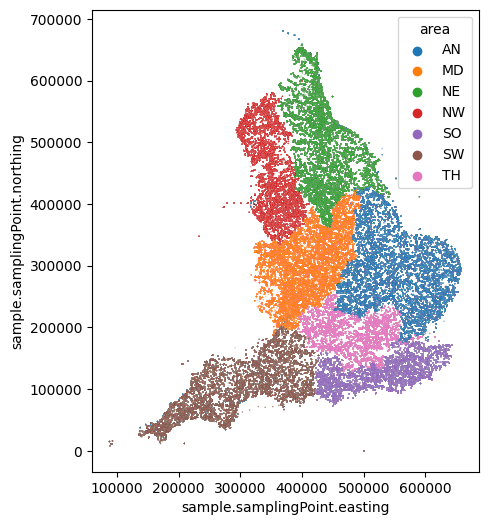

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect(aspect='equal')

sns.scatterplot(water, 
                x='sample.samplingPoint.easting', 
                y='sample.samplingPoint.northing',
                hue='area',
                s=1, alpha=.1, ax=ax)
plt.show()

The above plot is clearly a map of England (no Wales or Scotland) with 7 regions.   

(It is interesting that there appear to be a very small number of blue points for `AN` in the North of the plot, above the green `NE` points. There is also some blue around the coast of the brown `SW` area and red `NW` area, if you look carefully. That should really be investigated).  

The regions on the plot correspond closely to the 6 regions given at https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/302420/EAregions.pdf  :    


<img src="images/EAregions.png" height=400 width=290></img>  

So we amend the area names accordingly. (Note that 'South East' on the map is split into 'TH' and 'SO' in the plot, which I assume are 'Thames' and 'South' respectively).  



In [18]:
region_mapper = {'AN':'Anglian',
                 'MD':'Midlands',
                 'NE':'North East',
                 'NW':'North West',
                 'SO':'South',
                 'SW':'South West',
                 'TH':'Thames'}


# water['area'] = water['area'].map(region_mapper)

# since area has been loaded as a category, instead of mapping the whole df (as in the above line), 
# we can just rename the categories:

print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
water['area'] = water['area'].cat.rename_categories(new_categories=region_mapper)
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)



dataframe total memory usage: 2149.08 MB.    Shape: (29009573, 16)
dataframe total memory usage: 2149.08 MB.    Shape: (29009573, 16)


Similarly we can make a geographical plot of the different types of water and check it matches expectations:

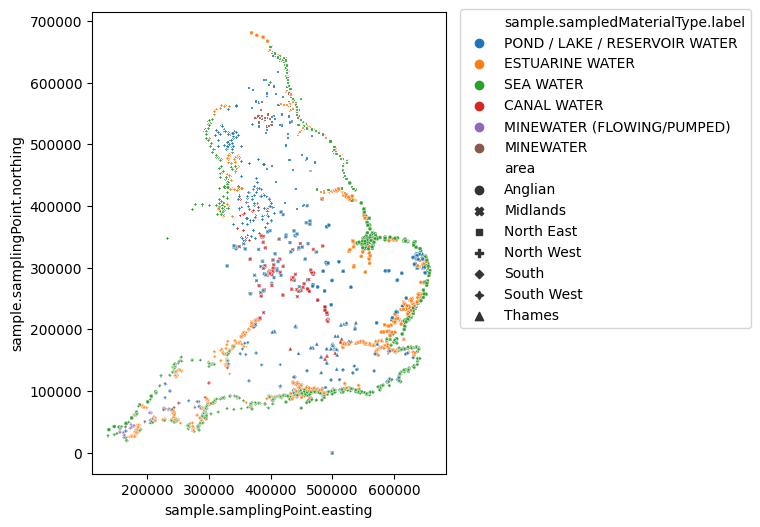

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect(aspect='equal')

material_types_to_plot = [
        # 'RIVER / RUNNING SURFACE WATER',
       'POND / LAKE / RESERVOIR WATER',
       'ESTUARINE WATER', 
       'SEA WATER',
       'CANAL WATER',
       'MINEWATER (FLOWING/PUMPED)', 'MINEWATER',]

plot = sns.scatterplot(
    data=water[water['sample.sampledMaterialType.label'].isin( material_types_to_plot)], 
        x='sample.samplingPoint.easting', 
        y='sample.samplingPoint.northing',
        hue='sample.sampledMaterialType.label', 
        hue_order=material_types_to_plot,
        style='area',
        s=5, alpha=.5, ax=ax)

sns.move_legend(plot, loc='upper left', bbox_to_anchor=(1.02, 1.02), )

plt.show()

As expected, measurements of Seawater are around the coast, of estuary water in the main estuaries e.g. the Thames estuary, lots of lake measurements in the Lake District and The Broads, etc.

### Determinand

There are several columns relating to determinand (measurement):
- `determinand.label`
- `determinand.definition`
- `determinand.notation`
- `determinand.unit.label`.   

Before simplifying the dataset, we need to check whether there is a one-to-one mapping between those columns.

In [20]:
# 1. ensure each reading (determinand) has the same definition always
# 2. ensure each reading (determinand) has the same notation always
# 3. ensure each reading (determinand) has the same unit (e.g. mg/l) always


groupby_determinand = water[[#'sample.samplingPoint', 'sample.samplingPoint.notation',
       # 'sample.samplingPoint.label', 'sample.sampleDateTime',
       'determinand.label', 'determinand.definition', 'determinand.notation',
       #'result', 'codedResultInterpretation.interpretation',
       'determinand.unit.label', 
       # 'sample.sampledMaterialType.label',
       #'sample.isComplianceSample', 'sample.purpose.label',
       # 'sample.samplingPoint.easting', 'sample.samplingPoint.northing'
              ]].groupby('determinand.label'
              ).agg(['nunique', #pd.unique, 
                   lambda x: pd.unique(x) if len(pd.unique(x))>1 else ''
                   ])

groupby_determinand_multiple_types = groupby_determinand[[ col for col in groupby_determinand.columns if col[1]=='nunique']].max(axis=1)>1
groupby_determinand[groupby_determinand_multiple_types].sort_values(by=[ col for col in groupby_determinand.columns if col[1]=='nunique']).tail(20)

determinand.definition  \
                                 nunique   
determinand.label                          
Colfm Conf                             2   
Colour                                 2   
E.coli C-MPN                           2   
GS Kurtosis                            2   
IsoPropylBen                           2   
OCDD                                   2   
Orthophospht                           2   
Phosphorus-P                           2   
SecButylbenz                           2   
Sld Sus@105C                           2   
Sulphate DWt                           2   
TertButylbnz                           2   
nButylbenzne                           2   
H2S                                    2   
E.coli PMF                             2   
StrepF PMF                             2   
CHLORONITROB                           3   
SHRIMP TOX                             3   
123789-HxCDD                           3   
ColfmF Conf                            3   

                                                                      \
                                                          <lambda_0>   
determinand.label                                                      
Colfm Conf         ['Coliforms, Total : Confirmed : MF : Wet Wt',...   
Colour             ['Colour', 'Sample Colour']
Categories (2951, ...   
E.coli C-MPN       ['Escherichia coli : Confirmed : MPN : Wet Wt'...   
GS Kurtosis        ['Grain Size Kurtosis', 'Grain Size Inclusive ...   
IsoPropylBen       ['Isopropylbenzene :- {Methylethylbenzene}', '...   
OCDD               ['Octachlorodibenzo-p-dioxin', 'Octachlorodibe...   
Orthophospht       ['Orthophosphate, reactive as P', 'Orthophosph...   
Phosphorus-P       ['Phosphorus, Total as P', 'Phosphorus : Load ...   
SecButylbenz       ['sec-Butylbenzene :- {1-Methylpropylbenzene}'...   
Sld Sus@105C       ['Solids, Suspended at 105 C', 'Solids, Suspen...   
Sulphate DWt       ['Sulphate : Dry Wt', 'Sulphate : Total : Dry ...   
TertButylbnz       ['tert-Butylbenzene :- {(1,1-Dimethylethyl)ben...   
nButylbenzne       ['n-ButylBenzene :- {1-Phenylbutane}', 'n-Buty...   
H2S                ['Hydrogen Sulphide', 'Hydrogen Sulphide as H2...   
E.coli PMF         ['Escherichia coli : Presumptive : MF', 'Esche...   
StrepF PMF         ['Streptococci : Faecal : Presumptive : MF', '...   
CHLORONITROB       ['1-Chloro-4-nitrobenzene :- {p-Chloronitroben...   
SHRIMP TOX         ['Toxicity Test : Shrimp, 4 Day : Semistatic L...   
123789-HxCDD       ['1,2,3,7,8,9-Hexachlorodibenzofuran', '1,2,3,...   
ColfmF Conf        ['Coliforms, Faecal : Confirmed', 'Coliforms, ...   

                  determinand.notation                      \
                               nunique          <lambda_0>   
determinand.label                                            
Colfm Conf                           2        [4082, 3840]   
Colour                               2          [69, 3388]   
E.coli C-MPN                         2         [3340, 939]   
GS Kurtosis                          2        [4914, 4873]   
IsoPropylBen                         2        [7574, 8275]   
OCDD                                 2        [8211, 8185]   
Orthophospht                         2          [180, 188]   
Phosphorus-P                         2         [348, 6013]   
SecButylbenz                         2        [6690, 8283]   
Sld Sus@105C                         2         [135, 3487]   
Sulphate DWt                         2        [6854, 6701]   
TertButylbnz                         2        [6697, 8282]   
nButylbenzne                         2        [6658, 8285]   
H2S                                  3   [7373, 8858, 914]   
E.coli PMF                           3  [2345, 7092, 3495]   
StrepF PMF                           3  [6423, 3493, 2548]   
CHLORONITROB                         3  [6614, 6613, 6612]   
SHRIMP TOX                           3  [7718, 7715, 7716]   
123789-HxCDD                         3  [8204,

So some determinand LABELS can have multiple definitions, notations, and units. We could split each determinand into the different types, but for simplicity we will just drop those determinands with  multiple definitions.

In [21]:
groupby_determinand_multiple_types_names = groupby_determinand_multiple_types.index[groupby_determinand_multiple_types]

print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
water = water[~water['determinand.label'].isin(groupby_determinand_multiple_types_names)]
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
# water


dataframe total memory usage: 2149.08 MB.    Shape: (29009573, 16)
dataframe total memory usage: 1869.39 MB.    Shape: (25046267, 16)


We can now check if all DEFINITIONS have more than one notation etc:

In [22]:
# 1. ensure each reading (determinand) has the same definition always
# 2. ensure each reading (determinand) has the same notation always
# 3. ensure each reading (determinand) has the same unit (e.g. mg/l) always


groupby_determinand = water[[#'sample.samplingPoint', 'sample.samplingPoint.notation',
       # 'sample.samplingPoint.label', 'sample.sampleDateTime',
       'determinand.label', 'determinand.definition', 'determinand.notation',
       #'result', 'codedResultInterpretation.interpretation',
       'determinand.unit.label', 
       # 'sample.sampledMaterialType.label',
       #'sample.isComplianceSample', 'sample.purpose.label',
       # 'sample.samplingPoint.easting', 'sample.samplingPoint.northing'
              ]].groupby('determinand.definition'
              ).agg(['nunique', #pd.unique, 
                   lambda x: pd.unique(x) if len(pd.unique(x))>1 else ''
                   ])

groupby_determinand_multiple_types = groupby_determinand[[ col for col in groupby_determinand.columns if col[1]=='nunique']].max(axis=1)>1
groupby_determinand[groupby_determinand_multiple_types].sort_values(by=[ col for col in groupby_determinand.columns if col[1]=='nunique']).tail(20)

determinand.label  \
                                                            nunique   
determinand.definition                                                
Iron, Leachable                                                   2   
Lead, Leachable                                                   2   
Manganese, Leachable                                              2   
Mercury, Leachable                                                2   
Nickel, Leachable                                                 2   
Odour : Phenolic                                                  2   
Oil                                                               2   
PCB - 052                                                         2   
Phage : F+ Coliphage                                              2   
Pyrene                                                            2   
Salinity : In Situ                                                2   
Solids, Volatile at 500 C                                         2   
Strontium, Leachable                                              2   
Turbidity                                                         2   
Vanadium, Leachable                                               2   
Zinc, Leachable                                                   2   
Flow, instantaneous                                               3   
Methyl-iso-Butyl-Ketone :- {4-Methylpentan-2-one}                 3   
Toluene :- {Methylbenzene}                                        3   
Trichloroethylene :- {Trichloroethene}                            3   

                                                                                                      \
                                                                                          <lambda_0>   
determinand.definition                                                                                 
Iron, Leachable                                    ['Fe Leach', 'Fe LeachDW']
Categories (3005, o...   
Lead, Leachable                                    ['Pb Std Leach', 'Pb LeachDW']
Categories (300...   
Manganese, Leachable                               ['Mn LeachDW', 'Mn Leach']
Categories (3005, o...   
Mercury, Leachable                                 ['Hg Std Leach', 'Hg LeachDW']
Categories (300...   
Nickel, Leachable                                  ['Ni Std Leach', 'Ni LeachDW']
Categories (300...   
Odour : Phenolic                                   ['OdourPhenolc', 'PhenolicOdor']
Categories (3...   
Oil                                                ['Oil PRES/NF', 'Oil']
Categories (3005, objec...   
PCB - 052                                          ['PCB Con 052', 'PCB - 052']
Categories (3005,...   
Phage : F+ Coliphage                               ['F+ColiphgPFU', 'F+Coliphage']
Categories (30...   
Pyrene                                             ['PYRENE', 'Pyrene']
Categories (3005, object)...   
Salinity : In Situ                                 ['Salinty in-f', 'SALinsitu']
Categories (3005...   
Solids, Volatile at 500 C                          ['Sld VSus@500', 'Sld V @ 500C']
Categories (3...   
Strontium, Leachable                               ['Sr Leach1:10', 'Sr Leach']
Categories (3005,...   
Turbidity                                          ['Turbidity', 'TurbidityNTU']
Categories (3005...   
Vanadium, Leachable                                ['V LeachDW', 'V Leach24']
Categories (3005, o...   
Zinc, Leachable                                    ['Zn Std Leach', 'Zn LeachDW']
Categories (300...   
Flow, instantaneous                                ['Flow l/s', 'Flow m3/s', 'INST.FLOW']
Categor...   
Methyl-iso-Butyl-Ketone :- {4-Methylpentan-2-one}  ['4-Methyl Pen', 'MIBK %', 'MIBK']
Categories ...   
Toluene :- {Methylbenzene}                         ['Toluene', 'TOLUENE %', 'TOLUENE']
Categories...   
Trichloroethylene :- {Trichloroethene}             ['Trichloroeth', 'TRICHLOR-E', 'TRIKE']
Catego...   

                       

and drop those too:

In [23]:
groupby_determinand_multiple_types_names = groupby_determinand_multiple_types.index[groupby_determinand_multiple_types]
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
water = water[~water['determinand.definition'].isin(groupby_determinand_multiple_types_names)]
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
# water


dataframe total memory usage: 1869.39 MB.    Shape: (25046267, 16)
dataframe total memory usage: 1751.07 MB.    Shape: (23369746, 16)


After dropping those rows, we can run the above cells again, and this time there are no determinands with multiple types.

### Combine `determinand.definition` and `determinand.unit.label` columns

E.g. from `BOD : 5 Day ATU` and `mg/l`, make `BOD : 5 Day ATU [mg/l]`

In [24]:
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)

water.insert(loc=water.columns.get_loc('determinand.label'), 
           column='determinand',
           value = (water['determinand.definition'].astype('string') + ' [' + 
                    water['determinand.unit.label'].astype('string') + ']'    
                    ).astype('category')
           )

print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)
# water 

dataframe total memory usage: 1751.07 MB.    Shape: (23369746, 16)
dataframe total memory usage: 1795.86 MB.    Shape: (23369746, 17)


### Drop columns we don't need
- `@id` is an API address for the observation - this was excluded when we originally loaded the `.csv` files
- `sample.samplingPoint` is an API address for the sampling point
- `sample.samplingPoint.notation` and `determinand.notation` are just notations for text labels, so we will keep just the labels  
- `codedResultInterpretation.interpretation` has a count of zero across all of 2022 for all observations
- `determinand.label` is included in `determinand.definition` which has been combined into the `determinand` column
- `determinand.definition` and `determinand.unit.label` have been combined into the `determinand` column
- `sample.isComplianceSample` and `sample.purpose.label` we just aren't interested in
- `sample.samplingPoint.easting` and `sample.samplingPoint.northing` give the location of the site, could potentially be interesting but not what we are interested in now

So all those columns will be dropped.


In [25]:
print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)

water = water[[
       # '@id', 'sample.samplingPoint', 'sample.samplingPoint.notation',
       'sample.samplingPoint.label', 'sample.sampleDateTime', 
       'determinand',
       # 'determinand.label', 'determinand.definition', 'determinand.notation',
       'result', 
       # 'codedResultInterpretation.interpretation',
       # 'determinand.unit.label', 
       'sample.sampledMaterialType.label',
       # 'sample.isComplianceSample', 'sample.purpose.label',
       # 'sample.samplingPoint.easting', 'sample.samplingPoint.northing',
       'area',
       ]]

print('dataframe total memory usage:', round(sys.getsizeof(water) / 1024**2, 2), 'MB.    Shape:', water.shape)

water

dataframe total memory usage: 1795.86 MB.    Shape: (23369746, 17)
dataframe total memory usage: 732.1 MB.    Shape: (23369746, 6)


,sample.samplingPoint.label,sample.sampleDateTime,determinand,result,sample.sampledMaterialType.label,area
2,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-01-04 14:10:00,BOD : 5 Day ATU [mg/l],7.5,FINAL SEWAGE EFFLUENT,Anglian
3,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-03-21 13:30:00,No flow /No sample [coded],0.0,FINAL SEWAGE EFFLUENT,Anglian
5,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-06-28 13:20:00,BOD : 5 Day ATU [mg/l],9.9,FINAL SEWAGE EFFLUENT,Anglian
8,BUCKINGHAM GOLF CLUB TINGEWICK RD.,2000-11-15 14:50:00,BOD : 5 Day ATU [mg/l],8.3,FINAL SEWAGE EFFLUENT,Anglian
19,ROBIN HOOD PH BUFFLERS HOLT,2000-01-04 13:50:00,No flow /No sample [coded],3.0,FINAL SEWAGE EFFLUENT,Anglian
...,...,...,...,...,...,...
66192987,HORNSEY WTW T/E SAMPLE POINT M,2022-03-23 07:18:00,No flow /No sample [coded],0.0,ANY TRADE EFFLUENT,Thames
66192988,HORNSEY WTW T/E SAMPLE POINT M,2022-05-14 08:05:00,No flow /No sample [coded],0.0,ANY TRADE EFFLUENT,Thames
66192989,HORNSEY WTW T/E SAMPLE POINT M,2022-07-18 08:04:00,No flow /No sample [coded],0.0,ANY TRADE EFFLUENT,Thames
66192990,HORNSEY WTW T/E SAMPLE POINT M,2022-09-29 11:19:00,No flow /No sample [coded],0.0,ANY TRADE EFFLUENT,Thames


### Get mean observation values for each location-year and each determinand 

There are multiple values for each location and determinand, taken at different times. This format isn't ideal, because we eventually will want to pivot the table so that certain determinands are columns of the table. If each row corresponds to an exact time, it is likely that after pivoting the table, that each row will only have one determinand for that exact time. So the dataset will be very sparse, with a lot of NaNs.  

To solve this issue, we take the mean over all observations made in a location over the year. Then, in the final pivoted table, each row will correspond to the mean for a location for a year. It is likely that there will be many rows which have several determinands and we will be able to make a dataset with no NaNs.


In [26]:
# unnecessarily complex version

# water['year'] = water['sample.sampleDateTime'].dt.year

# water_means = water.groupby(['area', 'sample.samplingPoint.label', 'sample.sampledMaterialType.label', 'determinand', 'year'],
#         observed=True,      #If True: only show observed values for categorical groupers
#                             # otherwise tries to make all poss combinations of all categorical groupers
#                             #which runs out of memory
#         ).agg(
#                             {'sample.sampleDateTime':sorted, 
#                              'result':[np.nanmean, np.nanstd]
#                              })

In [27]:
water['year'] = water['sample.sampleDateTime'].dt.year


water_means = water.drop(
    columns='sample.sampleDateTime').groupby(
        ['area', 'sample.samplingPoint.label', 'sample.sampledMaterialType.label', 'determinand', 'year'],
        observed=True,      #If True: only show observed values for categorical groupers
                            # otherwise tries to make all poss combinations of all categorical groupers...
                            # which runs out of memory
        ).mean()


print('dataframe total memory usage:', round(sys.getsizeof(water_means) / 1024**2, 2), 'MB.    Shape:', water_means.shape)

water_means

dataframe total memory usage: 67.21 MB.    Shape: (3686266, 1)


result
area    sample.samplingPoint.label         sample.sampledMaterialType.label determinand                          year            
Anglian BUCKINGHAM GOLF CLUB TINGEWICK RD. FINAL SEWAGE EFFLUENT            BOD : 5 Day ATU [mg/l]               2000    8.566667
                                                                                                                 2001   16.800000
                                                                                                                 2002   30.600000
                                                                                                                 2003   16.625000
                                                                                                                 2004    5.050000
...                                                                                                                           ...
Thames  FERRYMAN INN                       RIVER / RUNNING SURFACE WATER    Ammonia un-ionised as N [mg/l]       2022    0.000869
                                                                            Nitrogen, Total as N [mg/l]          2022    1.754167
                                                                            Alkalinity to pH 4.5 as CaCO3 [mg/l] 2022  256.666667
                                                                            Silica, reactive as SiO2 [mg/l]      2022    5.881818
                                                                            Oxygen, Dissolved as O2 [mg/l]       2022    6.615000

[3686266 rows x 1 columns]

In [28]:
# water_means = water_means.drop(columns=[('sample.sampleDateTime',  'sorted'), ('result',  'nanstd')])

# water_means.columns = [col[0] for col in water_means.columns]

# water_means

In [29]:
# water_means = water_means.index.rename(index={'sample.sampleDateTime':'year'})
# water_means 

### Choose which classes to include

There are multiple classes of water type, some of them having very little data, e.g. `MYTILUS EDULIS - MUSSEL - MUSCLE` (whatever that means). There is no point keeping such small classes.    

Secondly, the data includes clean fresh water, clean sea water, and sewage water; these will presumably be easily separable using salinity etc, so we will focus on clean and fresh water.    

So we now choose a few well-represented classes of clean fresh water:  


In [30]:
num_observations_each_water_type = water_means.reset_index()[
    ['sample.sampledMaterialType.label', 'result', ]
    ].groupby(['sample.sampledMaterialType.label', ]).count(
        ).reset_index().rename(columns={'result':'count'})#, level=1)#.sort_values(by=('result', 'count'))

water_idxs = (
   (num_observations_each_water_type['sample.sampledMaterialType.label'].str.contains('WATER'))
&  (~num_observations_each_water_type['sample.sampledMaterialType.label'].str.contains('TRADE'))
&  (~num_observations_each_water_type['sample.sampledMaterialType.label'].str.contains('SEDIMENT'))
&  (~num_observations_each_water_type['sample.sampledMaterialType.label'].str.contains('SEA'))
)

sewage_idxs = (
   (num_observations_each_water_type['sample.sampledMaterialType.label'].str.contains('SEWAGE'))
)


num_observations_each_water_type['type.category'] = 'other'
num_observations_each_water_type.iloc[water_idxs, num_observations_each_water_type.columns.get_loc('type.category')] = 'WATER'
num_observations_each_water_type.iloc[sewage_idxs, num_observations_each_water_type.columns.get_loc('type.category')] = 'sewage'

num_observations_each_water_type[num_observations_each_water_type['count']>100] .sort_values(by=['type.category', 'count'], ascending=[False, True])

,sample.sampledMaterialType.label,count,type.category
28,ANY SEWAGE,2349,sewage
53,CRUDE SEWAGE,44770,sewage
66,FINAL SEWAGE EFFLUENT,479697,sewage
24,ANY INVERTEBRATE - WHOLE ANIMAL,109,other
60,ESTUARY SEDIMENT - INTER TIDAL,253,other
30,ANY SHELLFISH (MOLLUSC & CRUSTACEAN) - WHOLE A...,260,other
19,ANY FLATFISH - MUSCLE,334,other
107,RUNNING SURFACE WATER SEDIMENT - <63UM FRACTION,521,other
145,STORM TANK INFLUENT,566,other
59,ESTUARY SEDIMENT - <63UM FRACTION,744,other


In [31]:
chosen_water_types = [
    # 'ANY WATER',       # too small
    #  'SEA WATER',                         # not fresh
    'MINEWATER',
    'CANAL WATER',
    'POND / LAKE / RESERVOIR WATER',
    'ESTUARINE WATER', 
    # 'GROUNDWATER - STATIC/UNPURGED',      # there is already another category for groundwater, unclear what the difference is
    # 'GROUNDWATER - PURGED/PUMPED/REFILLED' # ditto
    'GROUNDWATER',
    'RIVER / RUNNING SURFACE WATER']

In [32]:
print('dataframe total memory usage:', round(sys.getsizeof(water_means) / 1024**2, 2), 'MB.    Shape:', water_means.shape)
water_means = water_means.reset_index()
print('dataframe total memory usage:', round(sys.getsizeof(water_means) / 1024**2, 2), 'MB.    Shape:', water_means.shape)
water_means = water_means[water_means['sample.sampledMaterialType.label'].isin(chosen_water_types)].reset_index(drop=True)
water_means['sample.sampledMaterialType.label'] = water_means['sample.sampledMaterialType.label'].cat.remove_unused_categories()
print('dataframe total memory usage:', round(sys.getsizeof(water_means) / 1024**2, 2), 'MB.    Shape:', water_means.shape)
water_means 

dataframe total memory usage: 67.21 MB.    Shape: (3686266, 1)
dataframe total memory usage: 95.16 MB.    Shape: (3686266, 6)
dataframe total memory usage: 67.56 MB.    Shape: (2634976, 6)


,area,sample.samplingPoint.label,sample.sampledMaterialType.label,determinand,year,result
0,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2000,1.350000
1,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2001,1.511111
2,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2002,1.866667
3,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2003,1.990000
4,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2004,1.677778
...,...,...,...,...,...,...
2634971,Thames,FERRYMAN INN,RIVER / RUNNING SURFACE WATER,Ammonia un-ionised as N [mg/l],2022,0.000869
2634972,Thames,FERRYMAN INN,RIVER / RUNNING SURFACE WATER,"Nitrogen, Total as N [mg/l]",2022,1.754167
2634973,Thames,FERRYMAN INN,RIVER / RUNNING SURFACE WATER,Alkalinity to pH 4.5 as CaCO3 [mg/l],2022,256.666667
2634974,Thames,FERRYMAN INN,RIVER / RUNNING SURFACE WATER,"Silica, reactive as SiO2 [mg/l]",2022,5.881818


### Choose which determinands to include

There are multiple determinands (observation types), again some of them having very little data.   

So we now choose several well-represented determinands. Looking at the table and barchart below of counts for each determinand, we see most determinands have almost no representation, and there is a big jump for some determinands, which have a very high count.

There may be some dependency between the features (e.g. the two Oxygen ones are very suspect), so we will choose more than we need now and can cut it down later.


In [33]:
num_observations_each_determinand = water_means[
    ['determinand', 'result' ]
                        ].groupby(['determinand', ]).count(
                        ).rename(columns={'result' : 'count'}).sort_values(by='count').reset_index()

num_observations_each_determinand['determinand'] = num_observations_each_determinand['determinand'].astype(object)

num_observations_each_determinand #.tail(20) 

,determinand,count
0,Hexachlorobutadiene : Dry Wt [ug/kg],0
1,Streptococci : Faecal : Confirmed : MPN [no/10...,0
2,Chrysene + Triphenylene : Dry Wt [ug/kg],0
3,"Magnesium, Leachable [mg/l]",0
4,Chrysene : Wet Wt [ug/kg],0
...,...,...
1782,"Oxygen, Dissolved as O2 [mg/l]",123436
1783,"Nitrogen, Total Oxidised as N [mg/l]",128131
1784,"Oxygen, Dissolved, % Saturation [%]",137008
1785,pH [phunits],137184


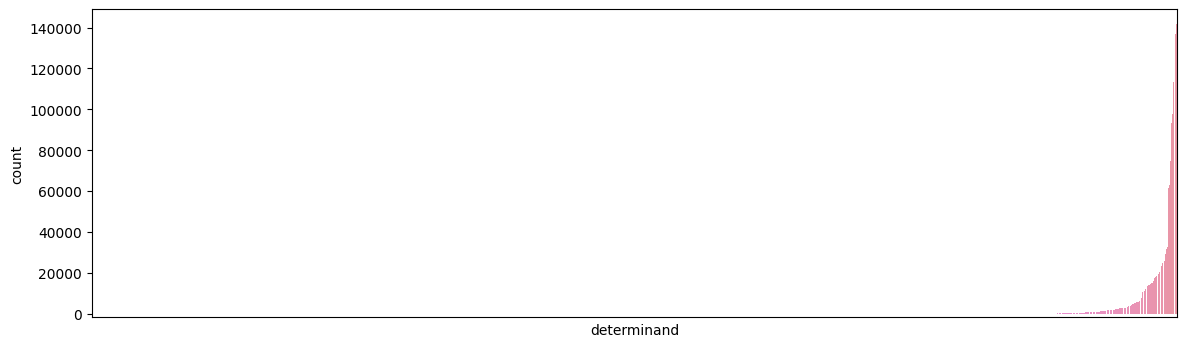

In [35]:
fig, ax = plt.subplots(figsize=(14,4))
sns.barplot(num_observations_each_determinand, x='determinand', y='count', ax=ax)

ax.set_xticks([])
ax.set_ylim(bottom=-ax.get_ylim()[1]*.01)
plt.show()  

So, many of the determinands are actually very sparsely represented in the dataset. To simplify the dataset, we need to eliminate those which are most infrequent.  

However we cannot simply choose the ones which are overall most frequent. If we did that, it would be possible that those determinands are only represented in say River Water and not in any of the other classes.   

Therefore we must choose determinands which are frequent over several classes.

In [36]:
num_observations_each_determinand = water_means[
    ['determinand', 'sample.sampledMaterialType.label', 'result',  ]
                        ].groupby(['determinand', 'sample.sampledMaterialType.label']).count(
                        ).rename(columns={'result' : 'count'}, ).sort_values(by='count')#.reset_index()

# num_observations_each_determinand.columns = ['determinand', 'count']

# pivot it
num_observations_each_determinand_pivoted = num_observations_each_determinand.reset_index(
    ).pivot(index='determinand', columns='sample.sampledMaterialType.label').fillna(0).astype(int)

# change col names
new_colnames = [name for _, name in num_observations_each_determinand_pivoted.columns]
num_observations_each_determinand_pivoted.columns = new_colnames

# order rows by sum
num_observations_each_determinand_pivoted['sum'] = num_observations_each_determinand_pivoted.sum(axis=1)
num_observations_each_determinand_pivoted = num_observations_each_determinand_pivoted.sort_values(by='sum')
num_observations_each_determinand_pivoted = num_observations_each_determinand_pivoted.drop(columns='sum')

# order cols by sum
col_order = sorted(num_observations_each_determinand_pivoted.columns, 
                    key=lambda col : num_observations_each_determinand_pivoted[col].sum(), reverse=True)
num_observations_each_determinand_pivoted = num_observations_each_determinand_pivoted[col_order]

num_observations_each_determinand_pivoted

,RIVER / RUNNING SURFACE WATER,GROUNDWATER,ESTUARINE WATER,POND / LAKE / RESERVOIR WATER,CANAL WATER,MINEWATER
determinand,,,,,,
Hexachlorobutadiene : Dry Wt [ug/kg],0,0,0,0,0,0
Streptococci : Faecal : Confirmed : MPN [no/100ml],0,0,0,0,0,0
Chrysene + Triphenylene : Dry Wt [ug/kg],0,0,0,0,0,0
"Magnesium, Leachable [mg/l]",0,0,0,0,0,0
Chrysene : Wet Wt [ug/kg],0,0,0,0,0,0
...,...,...,...,...,...,...
"Oxygen, Dissolved as O2 [mg/l]",97772,20450,3319,1045,799,51
"Nitrogen, Total Oxidised as N [mg/l]",105691,19226,1589,750,779,96
"Oxygen, Dissolved, % Saturation [%]",106312,21723,5928,1959,853,233


The stacked bar plot below illustrates that the determinands aren't equally spread across classes:

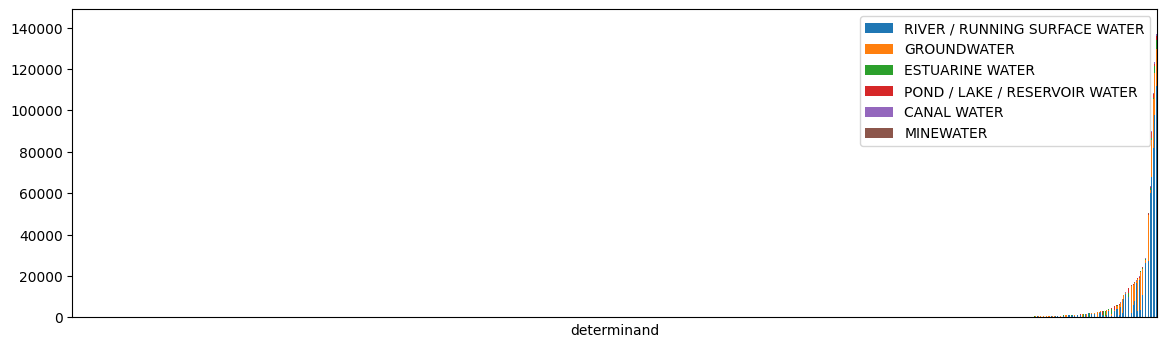

In [60]:

fig, ax=plt.subplots(figsize=(14,4))

num_observations_each_determinand_pivoted.plot(kind='bar', stacked=True, ax=ax)

ax.set_xticks([])
ax.set_ylim(bottom=-50)
plt.show()

We will choose determinands which occur a minimum of 500 times over the 5 different classes:

In [62]:
min_obs = 500

num_observations_common_determinands = num_observations_each_determinand_pivoted[
      (num_observations_each_determinand_pivoted['RIVER / RUNNING SURFACE WATER']>=min_obs)
    & (num_observations_each_determinand_pivoted['GROUNDWATER']>=min_obs)
    & (num_observations_each_determinand_pivoted['POND / LAKE / RESERVOIR WATER']>=min_obs)
    & (num_observations_each_determinand_pivoted['CANAL WATER']>=min_obs)
    & (num_observations_each_determinand_pivoted['ESTUARINE WATER']>=min_obs)   # doesn't seem to work well always
 ]

num_observations_common_determinands

,RIVER / RUNNING SURFACE WATER,GROUNDWATER,ESTUARINE WATER,POND / LAKE / RESERVOIR WATER,CANAL WATER,MINEWATER
determinand,,,,,,
BOD : 5 Day ATU [mg/l],60298,1028,977,651,620,1
Chloride [mg/l],46018,25485,1617,819,608,252
Nitrite as N [mg/l],90902,4457,1022,679,670,3
Nitrate as N [mg/l],93336,18063,1015,578,614,0
"Oxygen, Dissolved as O2 [mg/l]",97772,20450,3319,1045,799,51
"Nitrogen, Total Oxidised as N [mg/l]",105691,19226,1589,750,779,96
"Oxygen, Dissolved, % Saturation [%]",106312,21723,5928,1959,853,233
pH [phunits],111715,17994,4289,2052,834,300
Temperature of Water [cel],109105,23253,6088,2166,858,257


In [63]:
chosen_determinands = num_observations_common_determinands.index
chosen_water_types =  num_observations_common_determinands.columns[num_observations_common_determinands.min(axis=0)>=min_obs]
chosen_determinands, chosen_water_types

(CategoricalIndex([              'BOD : 5 Day ATU [mg/l]',
                                        'Chloride [mg/l]',
                                    'Nitrite as N [mg/l]',
                                    'Nitrate as N [mg/l]',
                         'Oxygen, Dissolved as O2 [mg/l]',
                   'Nitrogen, Total Oxidised as N [mg/l]',
                    'Oxygen, Dissolved, % Saturation [%]',
                                           'pH [phunits]',
                             'Temperature of Water [cel]'],
                  categories=[1,1,1,2-Tetrachloroethane [ug/l], 1,1,2,2-Tetrachloroethane [ug/l], 1,1,2-Trichloroethane [ug/l], 1,1-Dichloroethane [ug/l], ..., trans-Heptachlor epoxide [ug/l], trans-Permethrin : Dry Wt [ug/kg], trans-Permethrin : Wet Wt [ug/kg], trans-Permethrin [ug/l]], ordered=False, dtype='category', name='determinand'),
 Index(['RIVER / RUNNING SURFACE WATER', 'GROUNDWATER', 'ESTUARINE WATER',
        'POND / LAKE / RESERVOIR WATER', 'CANAL WA

we remove all other determinands from the dataset:

In [64]:
print('dataframe total memory usage:', round(sys.getsizeof(water_means) / 1024**2, 2), 'MB.    Shape:', water_means.shape)
water_means_chosen = water_means[
    (water_means['determinand'].isin(chosen_determinands))
    & (water_means['sample.sampledMaterialType.label'].isin(chosen_water_types))
    ].reset_index(drop=True)

water_means_chosen['sample.sampledMaterialType.label'] = water_means_chosen['sample.sampledMaterialType.label'].cat.remove_unused_categories()
water_means_chosen['determinand'] = water_means_chosen['determinand'].cat.remove_unused_categories()
water_means_chosen['sample.samplingPoint.label'] = water_means_chosen['sample.samplingPoint.label'].cat.remove_unused_categories()

    
print('dataframe total memory usage:', round(sys.getsizeof(water_means_chosen) / 1024**2, 2), 'MB.    Shape:', water_means_chosen.shape)
water_means_chosen 

dataframe total memory usage: 67.56 MB.    Shape: (2634976, 6)
dataframe total memory usage: 22.07 MB.    Shape: (1016006, 6)


,area,sample.samplingPoint.label,sample.sampledMaterialType.label,determinand,year,result
0,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2000,1.350000
1,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2001,1.511111
2,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2002,1.866667
3,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2003,1.990000
4,Anglian,R.OUSE A422 RD.BR.BRACKLEY,RIVER / RUNNING SURFACE WATER,BOD : 5 Day ATU [mg/l],2004,1.677778
...,...,...,...,...,...,...
1016001,Thames,FERRYMAN INN,RIVER / RUNNING SURFACE WATER,"Nitrogen, Total Oxidised as N [mg/l]",2022,1.497000
1016002,Thames,FERRYMAN INN,RIVER / RUNNING SURFACE WATER,Nitrite as N [mg/l],2022,0.020700
1016003,Thames,FERRYMAN INN,RIVER / RUNNING SURFACE WATER,Nitrate as N [mg/l],2022,1.361818
1016004,Thames,FERRYMAN INN,RIVER / RUNNING SURFACE WATER,"Oxygen, Dissolved, % Saturation [%]",2022,59.100000


Now we can re-plot the stacked bar chart using only the selected data:

In [65]:
num_observations_each_determinand_chosen = water_means_chosen[
    ['determinand', 'sample.sampledMaterialType.label', 'result', ]
                        ].groupby(['determinand', 'sample.sampledMaterialType.label']).count(
                        ).rename(columns={'result' : 'count'}, ).sort_values(by='count', )#.reset_index()


# pivot it
num_observations_each_determinand_chosen_pivoted = num_observations_each_determinand_chosen.reset_index(
    ).pivot(index='determinand', columns='sample.sampledMaterialType.label').fillna(0).astype(int)

# change col names
new_colnames = [name for _, name in num_observations_each_determinand_chosen_pivoted.columns]
num_observations_each_determinand_chosen_pivoted.columns = new_colnames

# order rows by sum
num_observations_each_determinand_chosen_pivoted['sum'] = num_observations_each_determinand_chosen_pivoted.sum(axis=1)
num_observations_each_determinand_chosen_pivoted = num_observations_each_determinand_chosen_pivoted.sort_values(by='sum')
num_observations_each_determinand_chosen_pivoted = num_observations_each_determinand_chosen_pivoted.drop(columns='sum')

# order cols by sum
col_order = sorted(num_observations_each_determinand_chosen_pivoted.columns, 
                    key=lambda col : num_observations_each_determinand_chosen_pivoted[col].sum(), reverse=True)
num_observations_each_determinand_chosen_pivoted = num_observations_each_determinand_chosen_pivoted[col_order]

num_observations_each_determinand_chosen_pivoted

,RIVER / RUNNING SURFACE WATER,GROUNDWATER,ESTUARINE WATER,POND / LAKE / RESERVOIR WATER,CANAL WATER
determinand,,,,,
BOD : 5 Day ATU [mg/l],60298,1028,977,651,620
Chloride [mg/l],46018,25485,1617,819,608
Nitrite as N [mg/l],90902,4457,1022,679,670
Nitrate as N [mg/l],93336,18063,1015,578,614
"Oxygen, Dissolved as O2 [mg/l]",97772,20450,3319,1045,799
"Nitrogen, Total Oxidised as N [mg/l]",105691,19226,1589,750,779
"Oxygen, Dissolved, % Saturation [%]",106312,21723,5928,1959,853
pH [phunits],111715,17994,4289,2052,834
Temperature of Water [cel],109105,23253,6088,2166,858


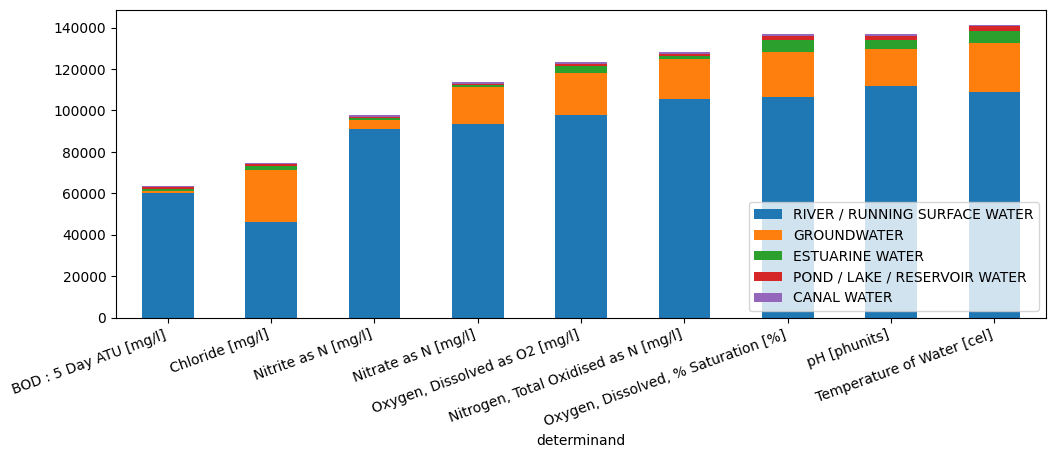

In [66]:

fig, ax=plt.subplots(figsize=(12,4))

num_observations_each_determinand_chosen_pivoted.plot(kind='bar', stacked=True, ax=ax)

ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=20, ha='right')
ax.set_ylim(bottom=-50)
plt.show()

### Pivot table

So that each determinand is a column, we pivot the table from being a list of determinands, to being a list of locations, each with multiple features (determinands):

In [67]:
print('dataframe total memory usage:', round(sys.getsizeof(water_means_chosen) / 1024**2, 2), 'MB.    Shape:', water_means_chosen.shape)

water_means_pivoted = water_means_chosen.pivot(
        index=['area', 'sample.sampledMaterialType.label', 'sample.samplingPoint.label', 'year',], 
        columns='determinand', values='result',).sort_index()

print('dataframe total memory usage:', round(sys.getsizeof(water_means_pivoted) / 1024**2, 2), 'MB.    Shape:', water_means_pivoted.shape)

water_means_pivoted 

dataframe total memory usage: 22.57 MB.    Shape: (1016006, 6)
dataframe total memory usage: 13.65 MB.    Shape: (154996, 9)


determinand                                                                             BOD : 5 Day ATU [mg/l]  \
area    sample.sampledMaterialType.label sample.samplingPoint.label               year                           
Anglian CANAL WATER                      GRAND UNION CANAL A4146 LAYBY            2000                3.175000   
                                                                                  2001                3.400000   
                                                                                  2002                4.680000   
                                         GRAND UNION CANAL BOWLERS BR.SIMPSON     2000                2.409091   
                                                                                  2001                2.875000   
...                                                                                                        ...   
Thames  RIVER / RUNNING SURFACE WATER    YEADING BROOK WEST AT THE WESTERN AVENUE 2018                     NaN   
                                                                                  2019                1.400000   
                                                                                  2020                1.600000   
                                                                                  2021                3.228571   
                                                                                  2022                     NaN   

determinand                                                                             Chloride [mg/l]  \
area    sample.sampledMaterialType.label sample.samplingPoint.label               year                    
Anglian CANAL WATER                      GRAND UNION CANAL A4146 LAYBY            2000        41.108333   
                                                                                  2001        33.675000   
                                                                                  2002        39.680000   
                                         GRAND UNION CANAL BOWLERS BR.SIMPSON     2000        48.991667   
                                                                                  2001        39.775000   
...                                                                                                 ...   
Thames  RIVER / RUNNING SURFACE WATER    YEADING BROOK WEST AT THE WESTERN AVENUE 2018              NaN   
                                                                                  2019              NaN   
                                                                                  2020              NaN   
                                                                                  2021              NaN   
                                                                                  2022              NaN   

determinand                                                                             Nitrate as N [mg/l]  \
area    sample.sampledMaterialType.label sample.samplingPoint.label               year                        
Anglian CANAL WATER                      GRAND UNION CANAL A4146 LAYBY            2000                  NaN   
                                                                                  2001                  NaN   
                                                                                  2002                  NaN   
                                         GRAND UNION CANAL BOWLERS BR.SIMPSON     2000                  NaN   
                                                                                  2001                  NaN   
...                                                                                                     ...   
Thames  RIVER / RUNNING SURFACE WATER    YEADING BROOK WEST AT THE WESTERN AVENUE 2018             2.980000   
                                                                                  2019             2.222857   
               

We see from the x-labels on the above stacked bar graph, that some of the determinands could be semi-duplicated by a similar determinand. For example, depending on which determinands have been chosen by the earlier part of the process, we may have two Oxygen determinands; or two for ammonia/ammoniacal nitrogen; or for copper; etc.   

To help us decide about which to keep, we can use a correlation heatmap. We order items alphabetically so that for example different Oxygen readings are adjacent:

In [44]:
def correlation_heatmap(df, most_correlated_first=True, figsize=(12,9.5),
                        cmap='bwr', annotation_dp=2, annotation_threshold=.5, 
                        annotation_diagonal=False, annotation_upper_triangle=False):

    corr = df.corr(numeric_only=True)

    if most_correlated_first:
        mean_corr = corr.abs().mean(axis=0)
        ordered_by_mean_corr = list(mean_corr.sort_values(ascending=False).index)
        print(ordered_by_mean_corr)
        corr = corr.loc[ordered_by_mean_corr, ordered_by_mean_corr]

    corr_annotations = corr.copy().applymap(
        lambda x:str(round(x, annotation_dp)).replace('0.', '.').replace('.0', '.')) #.round(annotation_dp).astype(str).replace('0.', '.')
    corr_annotations[corr.abs()<annotation_threshold] = ''

    for i in range(len(corr_annotations)):
        if not annotation_upper_triangle:
            corr_annotations.iloc[i,i+1:len(corr_annotations)] = ''
        if not annotation_diagonal:
            corr_annotations.iloc[i,i] = ''


    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, 
                vmin=-1, vmax=1, center=0, cmap=cmap, 
                annot=corr_annotations, fmt='', annot_kws=dict(size='x-small'),
                square=True, ax=ax)
    plt.show()



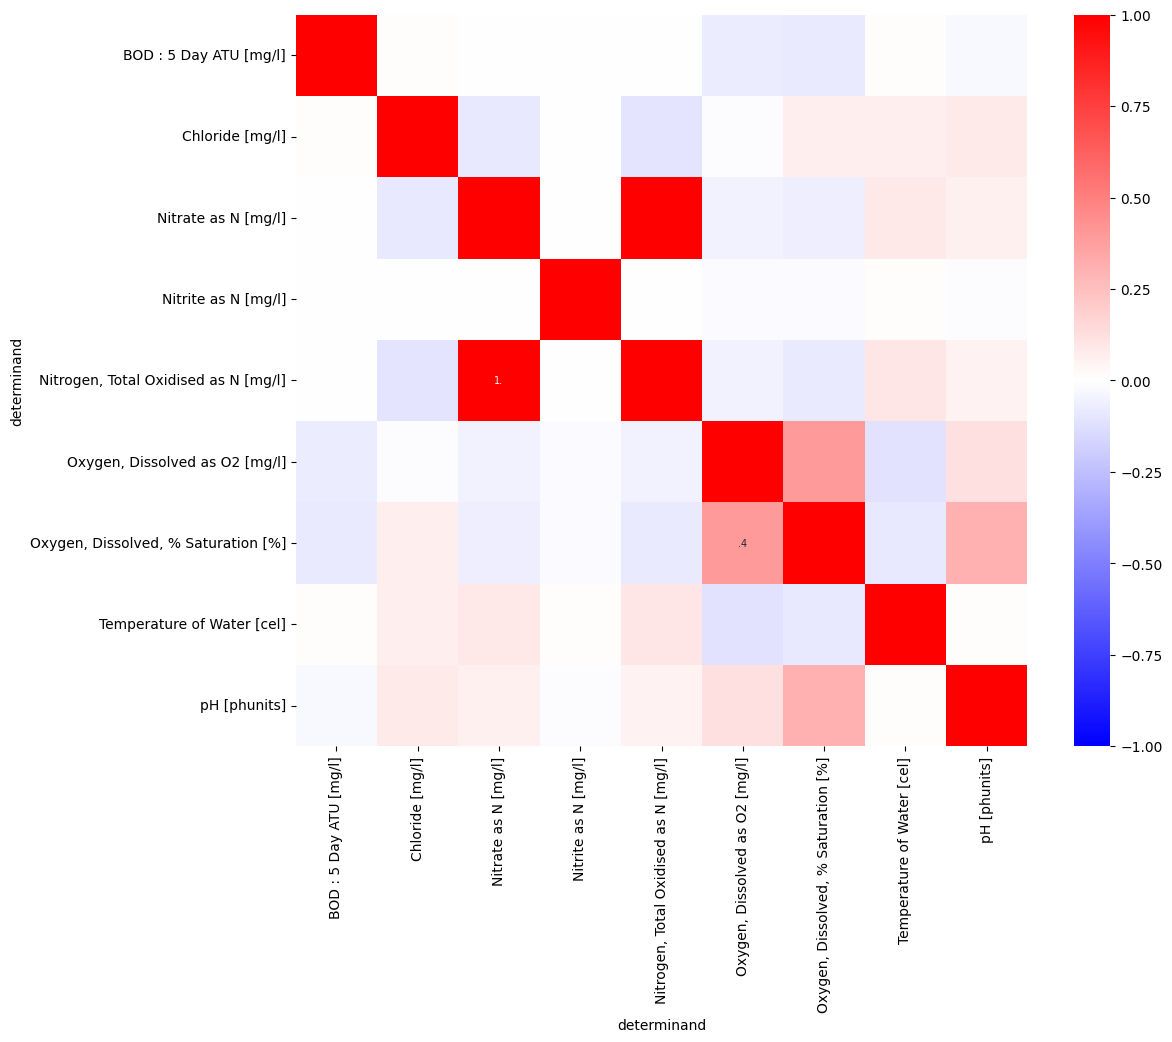

In [71]:

correlation_heatmap(df=water_means_pivoted, annotation_upper_triangle=0, most_correlated_first=0, annotation_threshold=.35)

##### Nitrogen / Nitrate

There is an extremely strong correlation between `Nitrogen, Total Oxidised as N [mg/l]` and `Nitrate as N [mg/l]`. This is explained with the following quote:  

> *Total oxidised nitrogen (TON) is the sum of nitrate and nitrite. Some countries monitor TON instead of nitrate. Nitrite levels are often much lower than nitrate, and therefore for the purposes of this assessment, nitrate and TON are considered to be approximately equivalent.*
> 
> \- https://www.eea.europa.eu/data-and-maps/figures/nitrate-or-total-oxidised-nitrogen-concentrations-in-different-sized-european-rivers

##### Oxygen

The link between `Oxygen, Dissolved as O2 [mg/l]` and `Oxygen, Dissolved, % Saturation [%]` is lower than expected. In a preliminary investigation which focused on a smaller subset of the data, there was a much higher correlation and it is surprising that that hasn't been replicated here. In any case I will remove one of the Oxygen determinands, as it won't be clear to the user what the difference is, and the aim is to make a user-friendly intuitive dataset.     

So we remove `Nitrogen, Total Oxidised as N [mg/l]` (and keep Nitrate and Nitrite), and we remove `Oxygen, Dissolved as O2 [mg/l]` (as of the two Oxygen determinands, this one is less common).  

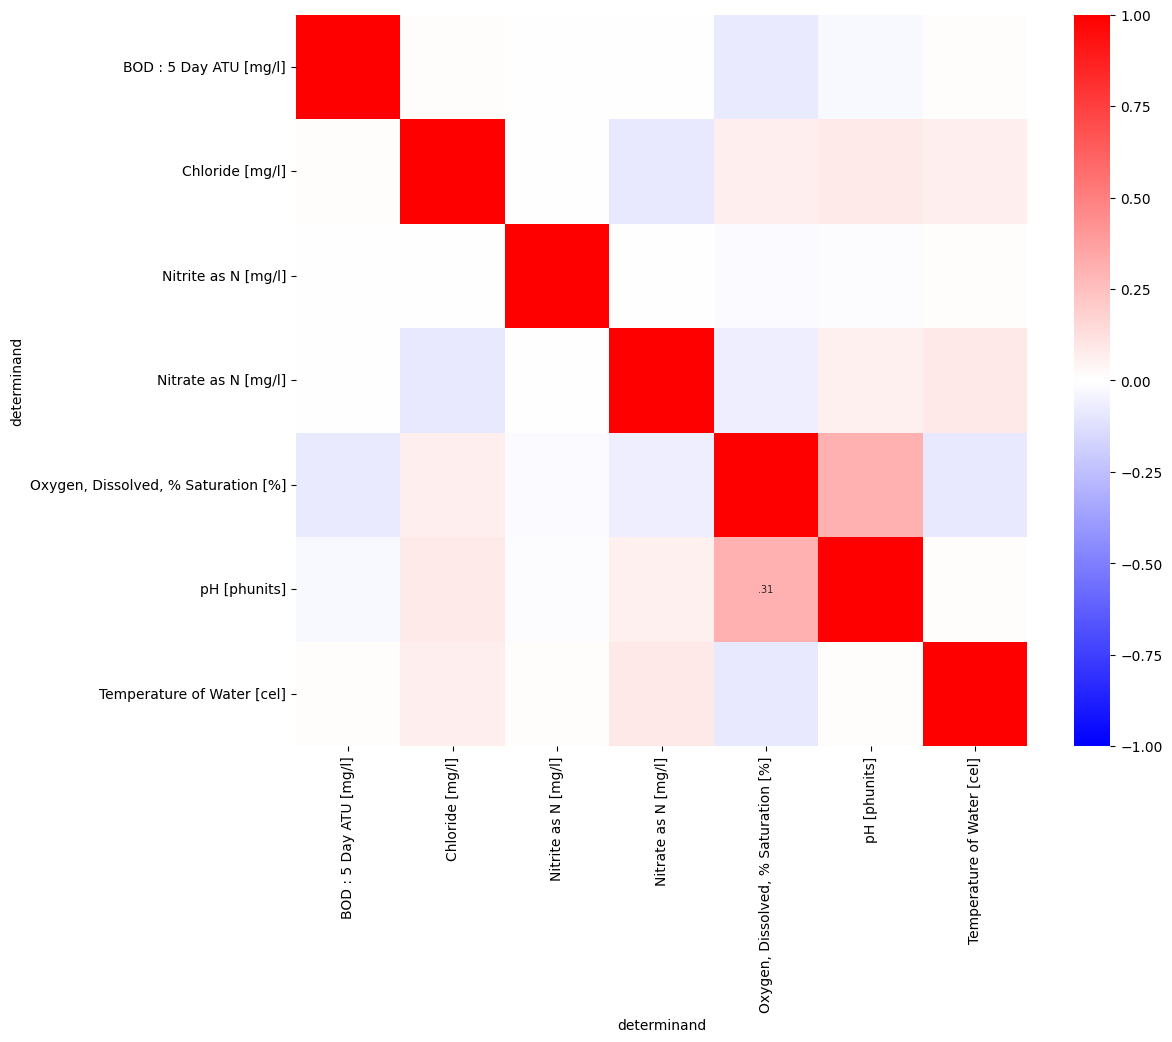

In [72]:

if (('Oxygen, Dissolved as O2 [mg/l]' in chosen_determinands) 
        and ('Oxygen, Dissolved, % Saturation [%]' in chosen_determinands)):
    chosen_determinands = [det for det in chosen_determinands if det!='Oxygen, Dissolved as O2 [mg/l]']

if (('Nitrogen, Total Oxidised as N [mg/l]' in chosen_determinands) 
        and ('Nitrate as N [mg/l]' in chosen_determinands)):
    chosen_determinands = [det for det in chosen_determinands if det!='Nitrogen, Total Oxidised as N [mg/l]']

water_means_pivoted = water_means_pivoted[chosen_determinands]

correlation_heatmap(df=water_means_pivoted, annotation_upper_triangle=0, most_correlated_first=0, annotation_threshold=.3)


So the 'duplicate' determinands have been removed, and there remain only determinands with fairly low correlations.   

[Note from when this was run on a smaller subset of the data:  
If there are still determinands with strong correlations, these are due to the nature of the dataset. E.g. Conductivity is correlated with Sodium, Calcium is obviously correlated with Calcium Carbonate. But they are not essentially duplicates. Any task using this dataset may wish to do feature selection considering these correlations,  but that is not a reason to remove them now - it is equally possible that a use of this dataset will be to model the correlation, e.g. to see how conductivity can be predicted from the minerals present in the water. Therefore these should be left in for now.]

### Drop nans

We want a dataset in which every row has readings from every determinand. Currently, there are a lot of nans in the dataset, since many locations for many years didn't have measurements for all of the chosen determinands. So there are relatively few rows which don't have any nans at all. We may need to remove further determinands in order to ensure there is sufficient data.  

In [73]:
water_means_pivoted.reset_index().groupby('sample.sampledMaterialType.label').count()[chosen_determinands]

determinand,BOD : 5 Day ATU [mg/l],Chloride [mg/l],Nitrite as N [mg/l],Nitrate as N [mg/l],"Oxygen, Dissolved, % Saturation [%]",pH [phunits],Temperature of Water [cel]
sample.sampledMaterialType.label,,,,,,,
CANAL WATER,620,608,670,614,853,834,858
ESTUARINE WATER,977,1617,1022,1015,5928,4289,6088
GROUNDWATER,1028,25485,4457,18063,21723,17994,23253
POND / LAKE / RESERVOIR WATER,651,819,679,578,1959,2052,2166
RIVER / RUNNING SURFACE WATER,60298,46018,90902,93336,106312,111715,109105


and the counts after all rows with any nans have been dropped:

In [74]:
counts = water_means_pivoted.dropna().reset_index().groupby('sample.sampledMaterialType.label').count()[chosen_determinands]
counts 

determinand,BOD : 5 Day ATU [mg/l],Chloride [mg/l],Nitrite as N [mg/l],Nitrate as N [mg/l],"Oxygen, Dissolved, % Saturation [%]",pH [phunits],Temperature of Water [cel]
sample.sampledMaterialType.label,,,,,,,
CANAL WATER,418,418,418,418,418,418,418
ESTUARINE WATER,459,459,459,459,459,459,459
GROUNDWATER,128,128,128,128,128,128,128
POND / LAKE / RESERVOIR WATER,181,181,181,181,181,181,181
RIVER / RUNNING SURFACE WATER,25962,25962,25962,25962,25962,25962,25962


So some of the classes are now very small. We could drop the class, or we could drop a chosen determinand. Let us see how the counts are affected by dropping one determinand:

In [75]:
# water_means_pivoted2 = water_means_pivoted.drop(columns='Zinc [ug/l]')
min_counts_no_drops = np.array(counts).min()
min_counts = min_counts_no_drops

for col in water_means_pivoted.columns:
    counts = water_means_pivoted.drop(columns=col).dropna().reset_index(
        ).groupby('sample.sampledMaterialType.label').count()[[det for det in chosen_determinands if det!=col]]
    print('if we remove', col, ', smallest class has', np.array(counts).min(), 'rows, instead of', min_counts_no_drops, 'if nothing dropped')
    if np.array(counts).min() > min_counts:
        best_to_remove = col
        min_counts = np.array(counts).min()

    # IPython.display.display(counts)

print()
print()
print()
print('  ********  best col to remove is', best_to_remove, 
    ', because if we remove', best_to_remove, ', smallest class has', min_counts, 
    'rows, instead of', min_counts_no_drops, 'if nothing dropped  ********  ')

if we remove BOD : 5 Day ATU [mg/l] , smallest class has 233 rows, instead of 128 if nothing dropped
if we remove Chloride [mg/l] , smallest class has 130 rows, instead of 128 if nothing dropped
if we remove Nitrite as N [mg/l] , smallest class has 142 rows, instead of 128 if nothing dropped
if we remove Nitrate as N [mg/l] , smallest class has 128 rows, instead of 128 if nothing dropped
if we remove Oxygen, Dissolved, % Saturation [%] , smallest class has 149 rows, instead of 128 if nothing dropped
if we remove pH [phunits] , smallest class has 129 rows, instead of 128 if nothing dropped
if we remove Temperature of Water [cel] , smallest class has 130 rows, instead of 128 if nothing dropped



  ********  best col to remove is BOD : 5 Day ATU [mg/l] , because if we remove BOD : 5 Day ATU [mg/l] , smallest class has 233 rows, instead of 128 if nothing dropped  ********  


So we have identified which determinand is best to remove. Now we remove it, and drop all rows with any nans:

In [76]:
chosen_determinands = [det for det in chosen_determinands if det!=best_to_remove]

water_means_pivoted = water_means_pivoted[chosen_determinands].dropna()
water_means_pivoted

determinand                                                                             Chloride [mg/l]  \
area    sample.sampledMaterialType.label sample.samplingPoint.label               year                    
Anglian CANAL WATER                      GRAND UNION CANAL BOWLERS BR.SIMPSON     2003        44.358333   
                                                                                  2004        49.581818   
                                                                                  2005        50.081818   
                                                                                  2006        57.941667   
                                                                                  2007        42.375000   
...                                                                                                 ...   
Thames  RIVER / RUNNING SURFACE WATER    WINGRAVE                                 2021        23.216667   
                                         WINTERBOURNE AT GAUGING STATION, BAGNOR  2002        25.358333   
                                         WYE AT GAUGING STATION, HEDSOR           2004        43.700000   
                                         YEADING BROOK AT HEADSTONE MANOR         2022        80.636364   
                                         YEADING BROOK EAST ABOVE PRIORS FARM, RU 2003        85.400000   

determinand                                                                             Nitrite as N [mg/l]  \
area    sample.sampledMaterialType.label sample.samplingPoint.label               year                        
Anglian CANAL WATER                      GRAND UNION CANAL BOWLERS BR.SIMPSON     2003             0.031309   
                                                                                  2004             0.029030   
                                                                                  2005             0.019450   
                                                                                  2006             0.014637   
                                                                                  2007             0.012400   
...                                                                                                     ...   
Thames  RIVER / RUNNING SURFACE WATER    WINGRAVE                                 2021             0.006000   
                                         WINTERBOURNE AT GAUGING STATION, BAGNOR  2002             0.008000   
                                         WYE AT GAUGING STATION, HEDSOR           2004             0.068800   
                                         YEADING BROOK AT HEADSTONE MANOR         2022             0.094182   
                                         YEADING BROOK EAST ABOVE PRIORS FARM, RU 2003             0.198500   

determinand                                                                             Nitrate as N [mg/l]  \
area    sample.sampledMaterialType.label sample.samplingPoint.label               year                        
Anglian CANAL WATER                      GRAND UNION CANAL BOWLERS BR.SIMPSON     2003             2.488545   
                                                                                  2004             2.973400   
                                                                                  2005             1.907500   
                                                                                  2006             0.360111   
                                                                                  2007             0.942000   
...                                                                                                     ...   
Thames  RIVER / RUNNING SURFACE WATER    WINGRAVE                                 2021             2.949333   
                                         WINTERBOURNE AT GAUGING STATION, BAGNOR  2002            10.200000   
                                         WYE AT GAUGIN

We can check that there are now good numbers for each determinand and for each class:

In [88]:
water_means_pivoted.reset_index().groupby('sample.sampledMaterialType.label').count()[chosen_determinands]

determinand,Chloride [mg/l],Nitrite as N [mg/l],Nitrate as N [mg/l],"Oxygen, Dissolved, % Saturation [%]",pH [phunits],Temperature of Water [cel]
sample.sampledMaterialType.label,,,,,,
CANAL WATER,452,452,452,452,452,452
ESTUARINE WATER,682,682,682,682,682,682
GROUNDWATER,2310,2310,2310,2310,2310,2310
POND / LAKE / RESERVOIR WATER,233,233,233,233,233,233
RIVER / RUNNING SURFACE WATER,29870,29870,29870,29870,29870,29870


### Make dataset balanced

The aim here is to make a small dataset, balanced across classes. Currently, the dataset is hugely imbalanced, with 100 times more observations of River Water than Pond / Lake water, as in the table above.    

To rectify this we create a function which randomly chooses samples from each class such that all classes have the same number of samples as the smallest class. Thus we achieve both aims of making the dataset smaller and balanced at the same time:

In [53]:
def equal_samples_by_class(df, class_colnames, num_each_class=None):
    
    class_labels = df[class_colnames]
    class_labels.insert(loc=len(class_colnames), column='index', value=class_labels.index)
    class_labels = class_labels.groupby(class_colnames).agg(['count', list])
    
    if num_each_class==None:
        num_each_class = class_labels[('index','count')].min()

    class_labels['chosen_idxs'] = class_labels[('index',  'list')].apply(
        lambda x : np.random.choice(a=x, size=num_each_class, replace=False))
    
    chosen_idxs = np.hstack(class_labels['chosen_idxs'].values)

    print('from the', len(df), 'rows in the dataframe: randomly choosing', len(chosen_idxs), 'rows,\n', 
            num_each_class, 'rows from each class in the', class_colnames, 'column(s),\n',
            'i.e. from each of the classes', list(class_labels.index))

    return df.loc[chosen_idxs]



In [ ]:
# equal_samples_by_class(df=water_means_pivoted.reset_index(), class_colnames=['area', 'sample.sampledMaterialType.label'])

# the following two lines ensure the dataset is balanced by area as well as by water type
# however that means a much smaller final dataset

# water_means_pivoted_equal_samples = equal_samples_by_class(df=water_means_pivoted.reset_index(), class_colnames=['area', ])
# water_means_pivoted_equal_samples = equal_samples_by_class(df=water_means_pivoted_equal_samples, class_colnames=['sample.sampledMaterialType.label'])


In [109]:
np.random.seed(42)

In [110]:

water_means_pivoted_equal_samples = equal_samples_by_class(
    df=water_means_pivoted.reset_index(), class_colnames=['sample.sampledMaterialType.label']
    )

water_means_pivoted_equal_samples

from the 33547 rows in the dataframe: randomly choosing 1165 rows,
 233 rows from each class in the ['sample.sampledMaterialType.label'] column(s),
 i.e. from each of the classes ['CANAL WATER', 'ESTUARINE WATER', 'GROUNDWATER', 'POND / LAKE / RESERVOIR WATER', 'RIVER / RUNNING SURFACE WATER']


determinand,area,sample.sampledMaterialType.label,sample.samplingPoint.label,year,Chloride [mg/l],Nitrite as N [mg/l],Nitrate as N [mg/l],"Oxygen, Dissolved, % Saturation [%]",pH [phunits],Temperature of Water [cel]
5357,Midlands,CANAL WATER,TAME VALLEY CANAL NEWTON ROAD,2002,51.966667,0.016455,1.404000,102.583333,7.916667,11.550000
5097,Midlands,CANAL WATER,BALLS HILL BRANCH CNL PHOENIX ST W.BROM,2004,86.018182,0.032100,0.762455,77.545455,6.609091,12.445455
5394,Midlands,CANAL WATER,TRENT & MERSEY CANAL - HEM HEATH,2008,45.733333,0.007771,0.974833,85.250000,7.857500,10.246667
5390,Midlands,CANAL WATER,TRENT & MERSEY CANAL - HEM HEATH,2004,41.246154,0.013077,1.508692,83.461538,7.723077,11.376923
5211,Midlands,CANAL WATER,"G/S CANAL, SPLATT BRIDGE",2005,43.983333,0.060667,5.597500,93.833333,8.058333,13.700000
...,...,...,...,...,...,...,...,...,...,...
15136,Midlands,RIVER / RUNNING SURFACE WATER,"WOODHOUSE SEWER, CONF, HATFIELD WSTE DR",2015,98.266667,0.288067,16.557500,65.700000,7.755833,10.616667
4456,Anglian,RIVER / RUNNING SURFACE WATER,SKELLINGTHORPE MAIN DRN.D/S STW,2013,97.566667,0.203258,7.500000,66.930769,7.472308,10.130769
18770,North East,RIVER / RUNNING SURFACE WATER,TEAM U/S SLEDGEHILL WASTE DISPOSAL SITE,2004,56.600000,0.133500,7.670000,88.909091,7.541667,9.008333
4401,Anglian,RIVER / RUNNING SURFACE WATER,SAPISTON R. BARDWELL RD.BR.,2006,64.500000,0.038258,8.716667,87.133333,8.000833,10.646667


### Visualise dataset

We now graph pair plots of all the determinands in the dataset. To do so we import my `enhanced_pair_plot` function, which draws:   
- top triangle: regression plots, annotated with the correlation coefficient and p-value for each class  
- lower triangle: KDE plots, annotated with the mutual information between each pair of determinands
- diagonal: histograms for the distribution of each determinand, annotated with mean and standard deviation, and the Kolmogorov-Smirnov test of whether the standardised data is normally distributed.

In [111]:
import enhanced_pair_plot

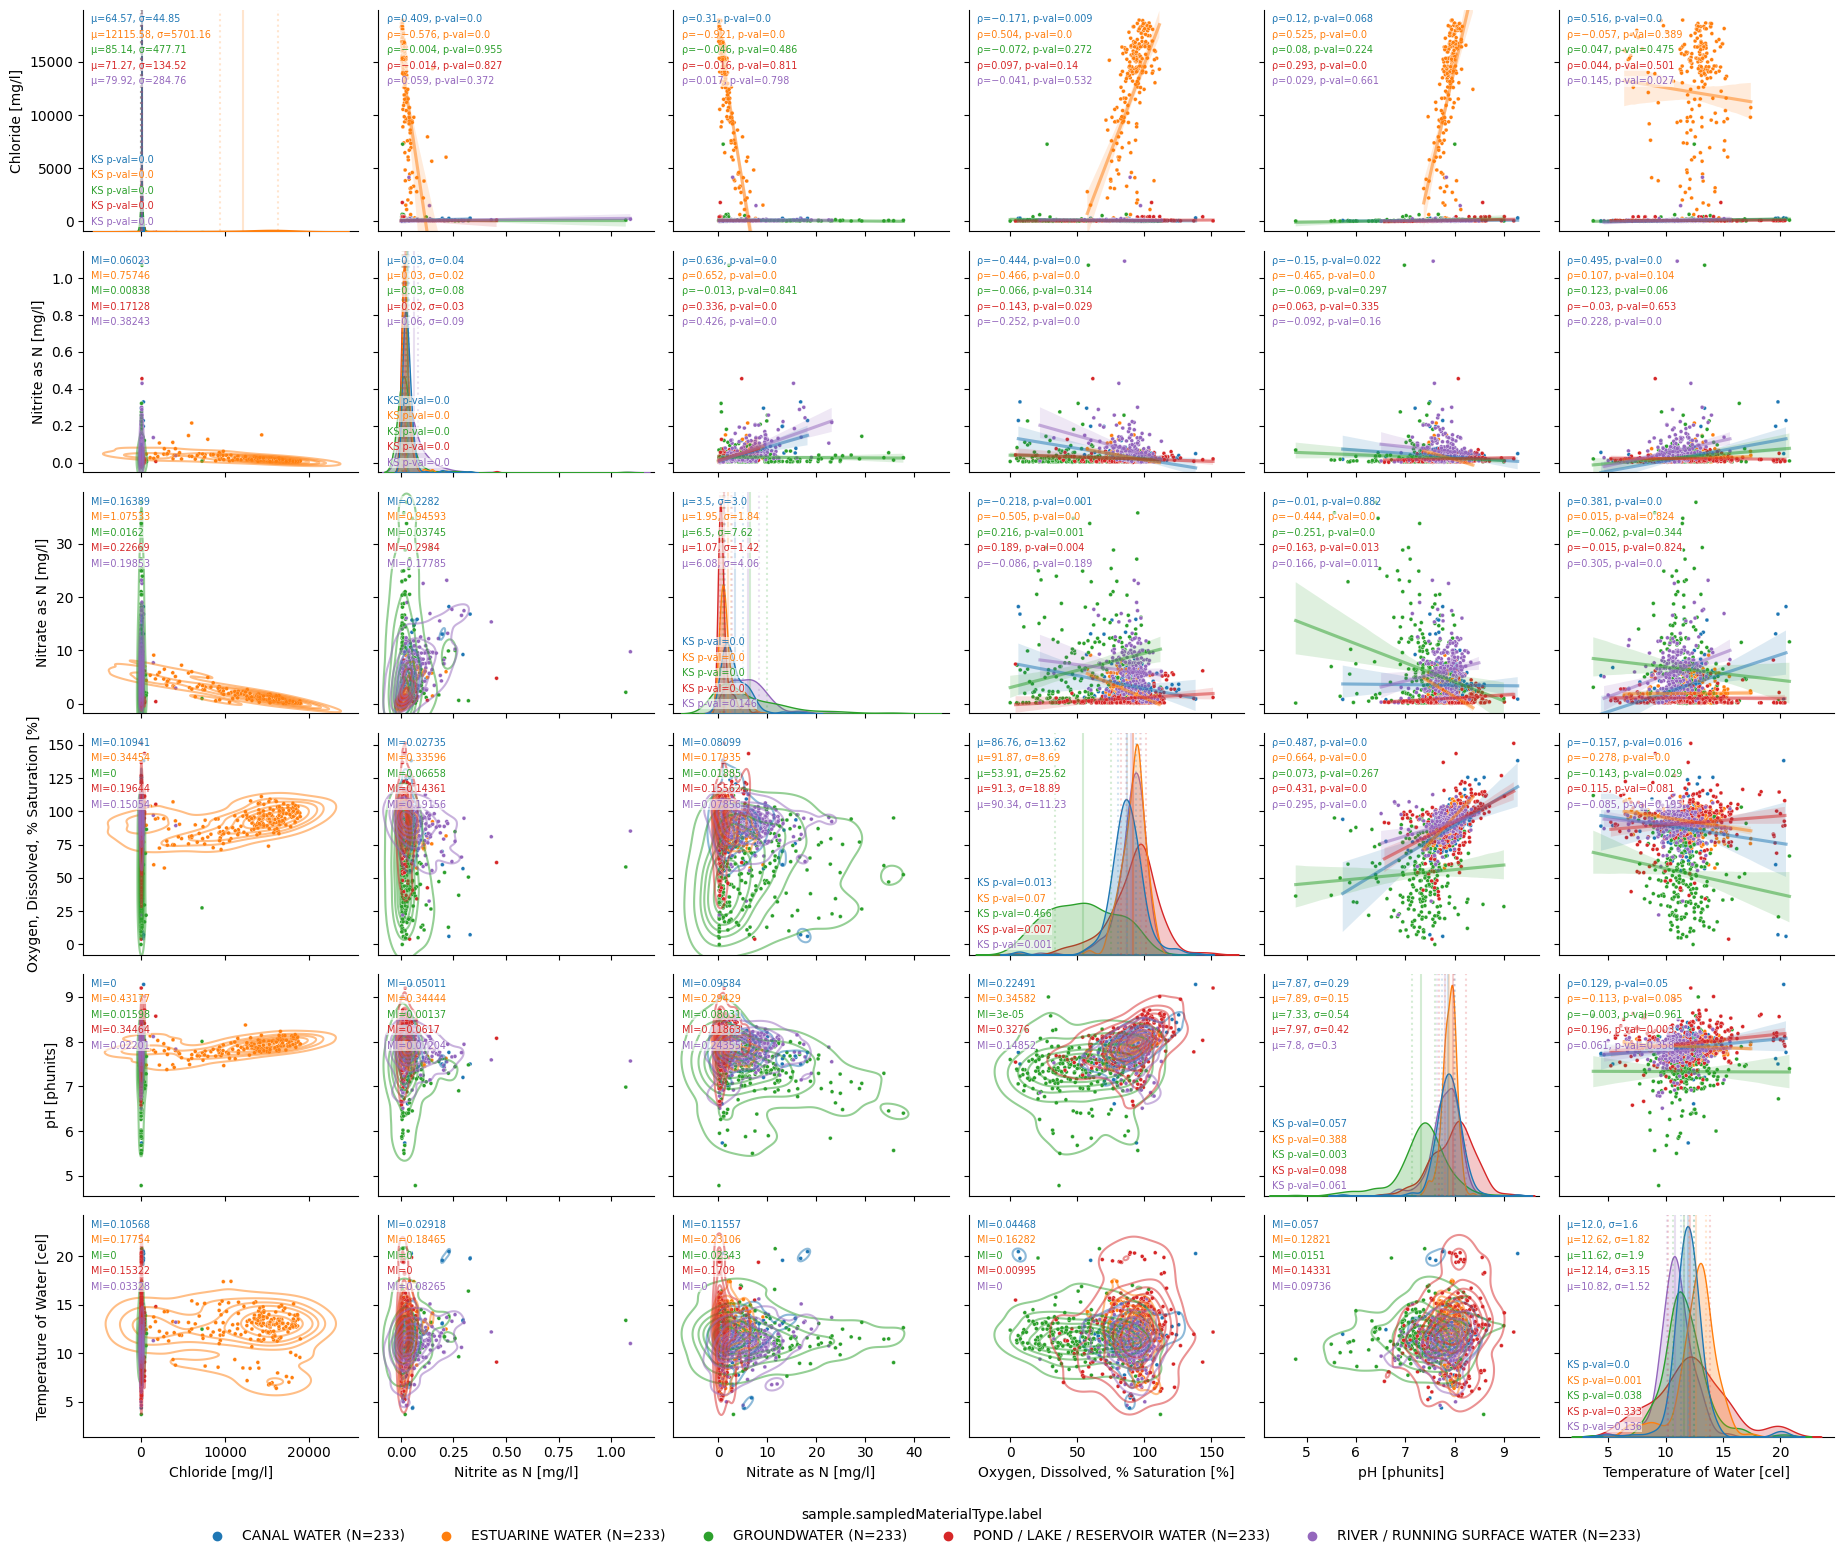

In [112]:
water_means_pivoted_equal_samples_visualise_water_type = water_means_pivoted_equal_samples.drop(columns=['sample.samplingPoint.label', 'area', 'year',])

enhanced_pair_plot.enhanced_pair_plot(df=water_means_pivoted_equal_samples_visualise_water_type, hue='sample.sampledMaterialType.label')

The above plots make several points clear. A few examples:  
- Estuaries have far more chloride in them. Presumably this is due to higher salinity (salt = Sodium Chloride) due to salt moving into the estuaries from the sea.  
- In estuaries, the amount of chloride is highly correlated to other determinands; whereas in other water types such as lakes there is no correlation. This could also be due to the above logic - where the estuary has a lot of flow from the sea (e.g. very close to the sea), there will be a lot of chloride and also a lot of other chemicals which come from the sea. This is of course simple speculation, I don't know enough about estuaries and water to be confident.  
- There is generally less oxygen in groundwater, which makes sense
- Nitrate and Nitrite have a strong correlation and high MI in all water types - apart from in groundwater, where there is no correlation and low MI
- etc.

### Make simple classifiers

To finish off, we train a few simple classifiers from `sklearn` on the dataset, and record the scores on a test chunk:

In [117]:
train, test = sklearn.model_selection.train_test_split(water_means_pivoted_equal_samples, random_state=42)
# test

#### Classifying water type

In [130]:
clfs = [sklearn.linear_model.LogisticRegression(max_iter=50000, random_state=42),
        sklearn.tree.DecisionTreeClassifier(random_state=42),
        sklearn.ensemble.RandomForestClassifier(n_estimators=500, random_state=42),
        sklearn.ensemble.AdaBoostClassifier(n_estimators=100, random_state=42),
        sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, random_state=42),
        sklearn.neighbors.KNeighborsClassifier(n_neighbors=3,  weights='distance'),
        ]



for clf in clfs:
    clf.fit(X=train[chosen_determinands],
            y=train['sample.sampledMaterialType.label'])

    score = clf.score(X=test[chosen_determinands],
            y=test['sample.sampledMaterialType.label'])     

    print(clf, score)

LogisticRegression(max_iter=50000, random_state=42) 0.708904109589041
DecisionTreeClassifier(random_state=42) 0.702054794520548
RandomForestClassifier(n_estimators=500, random_state=42) 0.821917808219178
AdaBoostClassifier(n_estimators=100, random_state=42) 0.6404109589041096
GradientBoostingClassifier(random_state=42) 0.821917808219178
KNeighborsClassifier(n_neighbors=3, weights='distance') 0.7397260273972602


This can certainly be improved on, and it would be interesting to see which features are the most important for classification. But these scores clearly confirm that the determinands provided provide some basis for the classification of what type of water it is.  


#### Classifying area of origin

In the next cell we see that classifying samples for area of origin is harder on the basis of these determinands:  

In [131]:
clfs = [sklearn.linear_model.LogisticRegression(max_iter=50000, random_state=42),
        sklearn.tree.DecisionTreeClassifier(random_state=42),
        sklearn.ensemble.RandomForestClassifier(n_estimators=500, random_state=42),
        sklearn.ensemble.AdaBoostClassifier(n_estimators=100, random_state=42),
        sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, random_state=42),
        sklearn.neighbors.KNeighborsClassifier(n_neighbors=3,  weights='distance'),
        ]



for clf in clfs:
    clf.fit(X=train[chosen_determinands],
            y=train['area'])

    score = clf.score(X=test[chosen_determinands],
            y=test['area'])     

    print(clf, score)

LogisticRegression(max_iter=50000, random_state=42) 0.5205479452054794
DecisionTreeClassifier(random_state=42) 0.523972602739726
RandomForestClassifier(n_estimators=500, random_state=42) 0.5924657534246576
AdaBoostClassifier(n_estimators=100, random_state=42) 0.3664383561643836
GradientBoostingClassifier(random_state=42) 0.565068493150685
KNeighborsClassifier(n_neighbors=3, weights='distance') 0.5102739726027398


This is unsurprising as each area is a collection of multiple catchment areas which will all have their own unique characteristics, so each class isn't really one distinct class. 

### Save dataset

For easy access:

In [132]:
water_means_pivoted_equal_samples.to_csv('water.csv')
water_means_pivoted_equal_samples.to_pickle('water.pkl')
